# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

# Часть 1. SVM, LR и калибровка вероятностей

In [2]:
# !pip install --upgrade scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = 8, 5

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт один из двух классов с равными вероятностями. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
np.random.seed(42)

# наш случайный классификатор
y_random = np.random.choice([0, 1], size=len(y_test), p=[0.5, 0.5])
y_random

array([0, 1, 1, ..., 0, 0, 1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно, за особенно эффективные или красивые варианты может быть начислен небольшой бонус :)

In [4]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import make_scorer

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from mlxtend.plotting import plot_decision_regions
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

AUC-PR: 0.63340
AUC-ROC: 0.50394


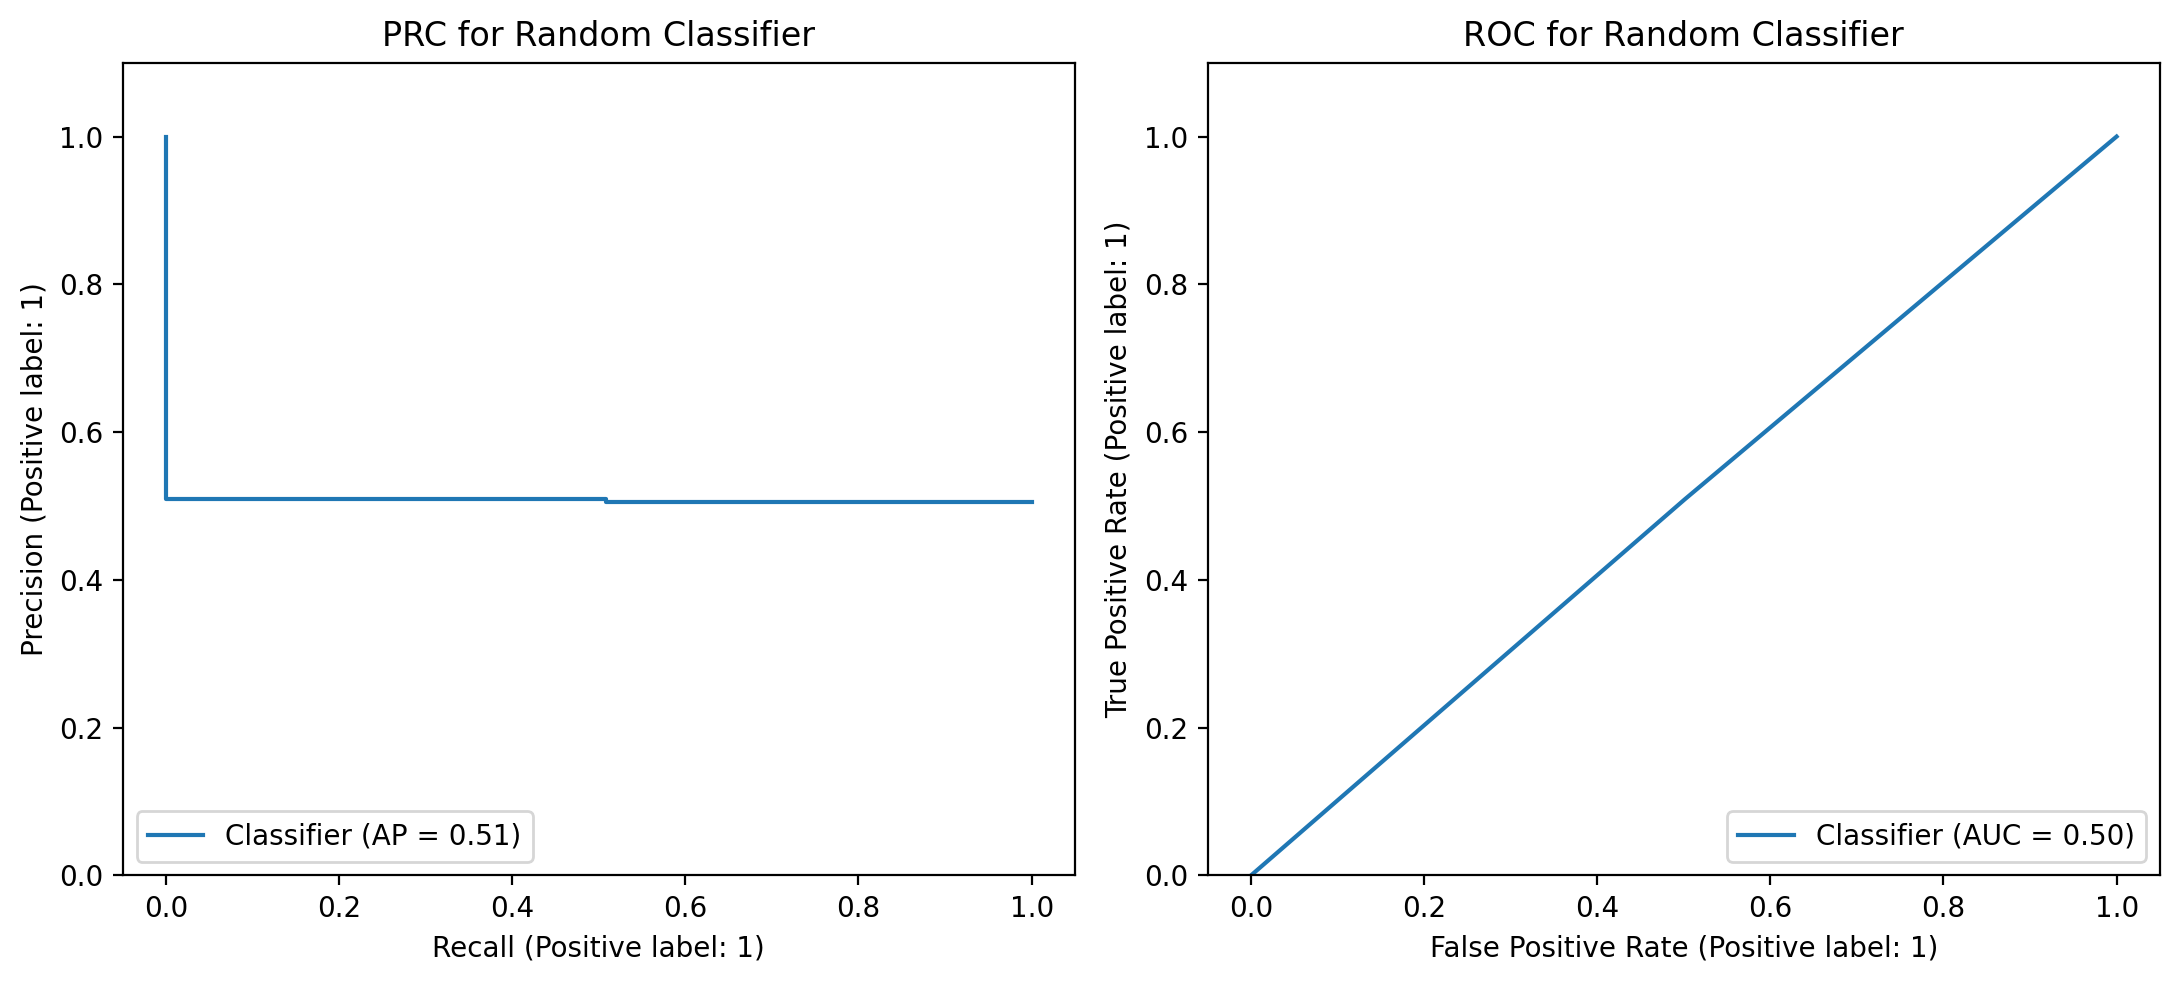

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_random)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_random))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [6]:
# dataframe для сравнения 
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])

# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_random),
    None
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).

__NB!__ Здесь и далее, если не сказано иначе, подбирайте __оптимальные гиперпараметры с точки зрения AUC-PR.__

In [7]:
def auc_pr(y, y_pred):
    '''
    Функция, которая считает значение площади под PR кривой (precision - recall)
    для случая бинарной классификации.
    Основана на предложенном пайплайне

    y - истинные тергеты (классы)
    y_pred - выходы модели
    '''
    precision, recall, _ = precision_recall_curve(y, y_pred)
    return auc(recall, precision)

In [8]:
# создаем scorer для GridSearchCV
auc_pr_scorer = make_scorer(auc_pr)

# будем перебирать:
coefs_C = np.linspace(1e-4, 1, 20)

In [9]:
searcher_svm = GridSearchCV(LinearSVC(max_iter=100000, random_state=13), param_grid=[{"C": coefs_C}], scoring=auc_pr_scorer, cv=10)
searcher_svm.fit(X_train, y_train)

best_C_svm = searcher_svm.best_params_["C"]
print("Best C = %.5f" % best_C_svm)

Best C = 0.05273


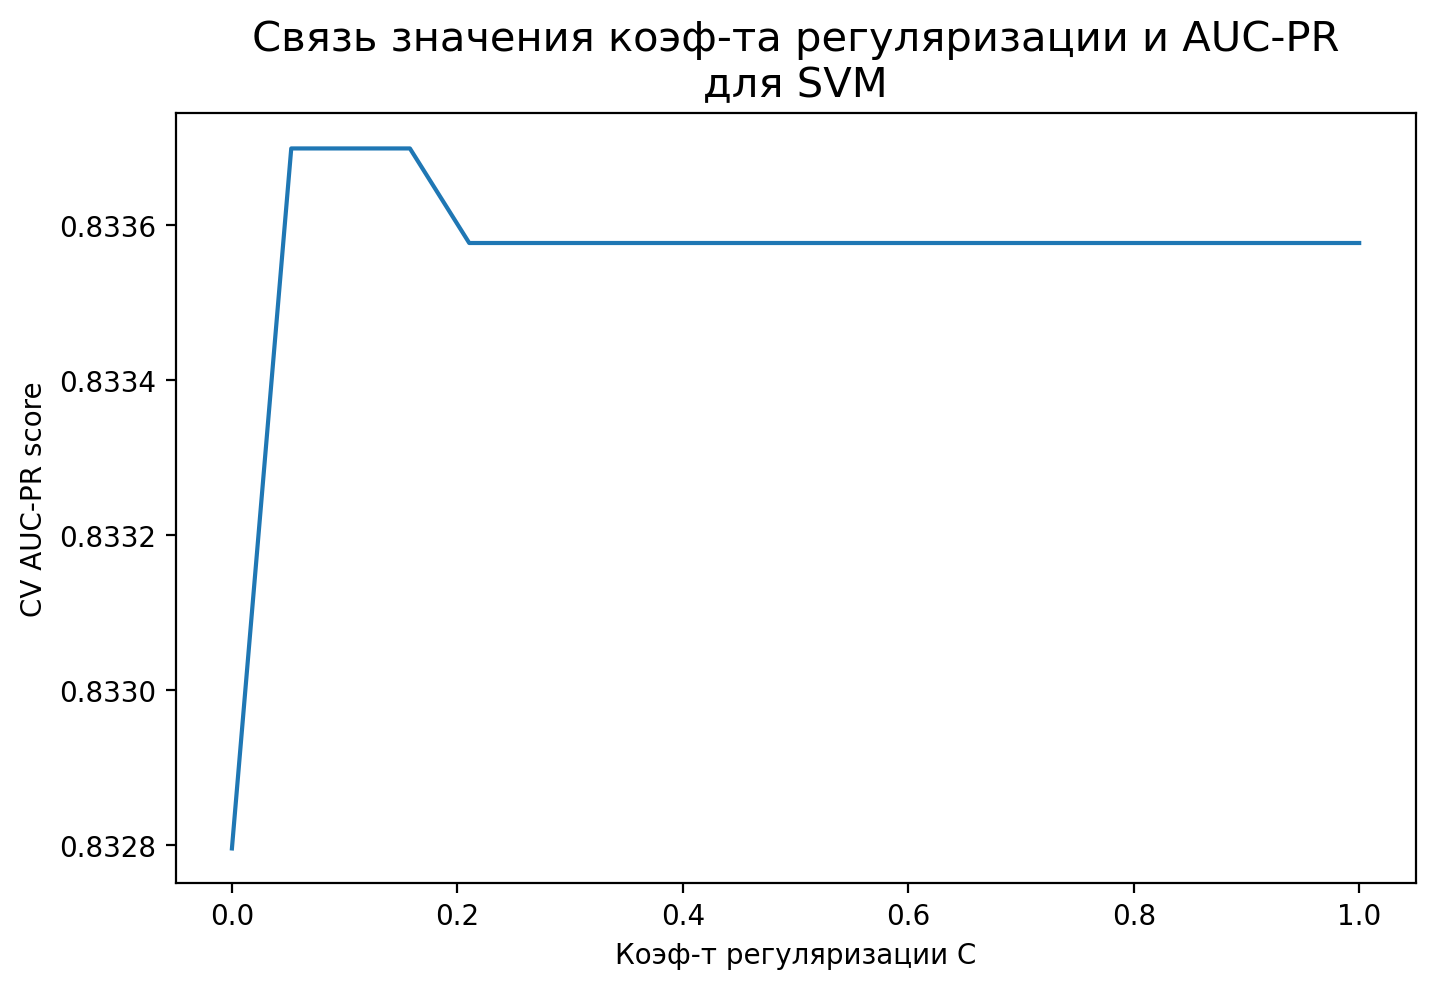

In [10]:
plt.plot(coefs_C, searcher_svm.cv_results_["mean_test_score"])
plt.title('Связь значения коэф-та регуляризации и AUC-PR\nдля SVM', fontsize=15)
plt.xlabel("Коэф-т регуляризации C")
plt.ylabel("CV AUC-PR score");

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

In [11]:
svc = LinearSVC(max_iter=100000, random_state=13, C=best_C_svm).fit(X_train, y_train)
y_pred_svm = svc.decision_function(X_test)

AUC-PR: 0.82968
AUC-ROC: 0.84765


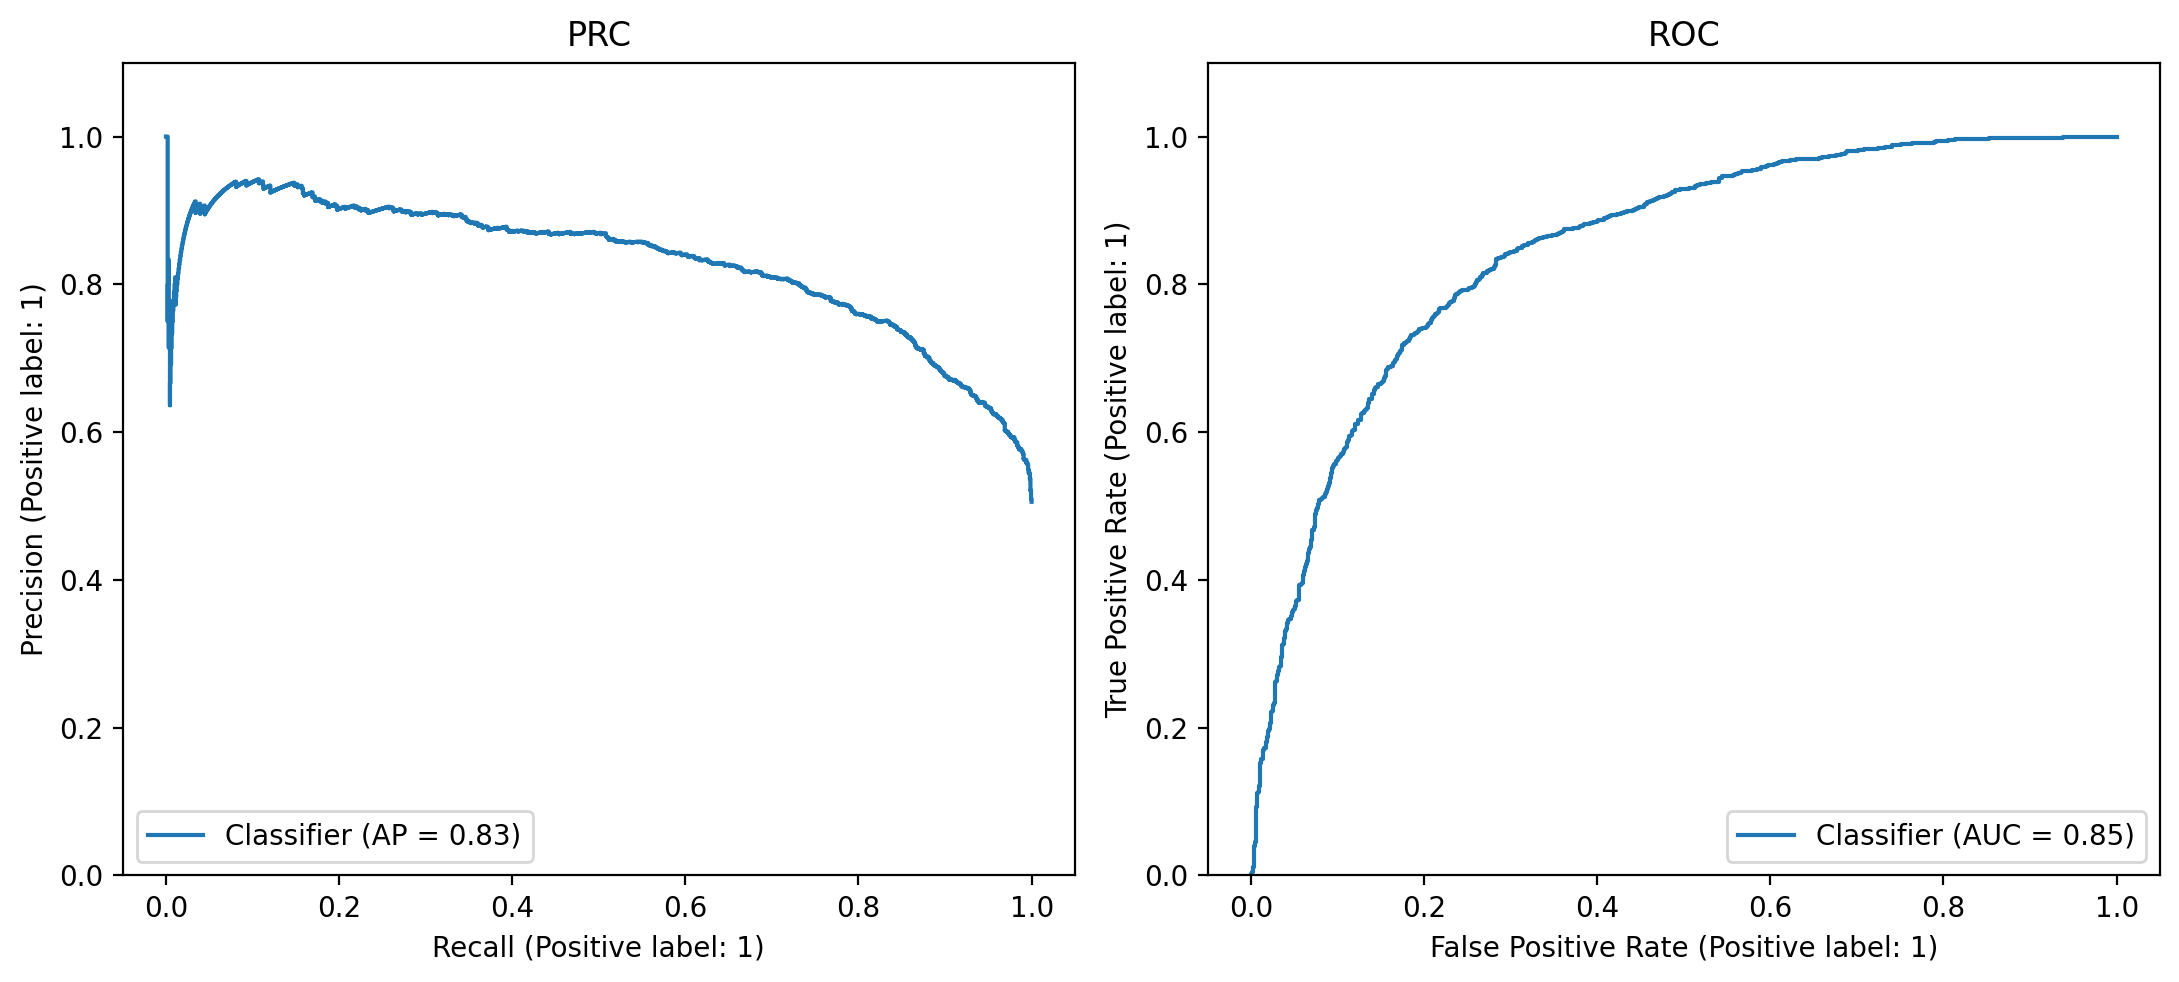

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_pred_svm, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_pred_svm)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_pred_svm, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_pred_svm))
ax[1].set_title("ROC")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [13]:
# добавление SVM
df_metrics.loc['SVM Classifier'] = [
    auc_pr(y_test, y_pred_svm),
    roc_auc_score(y_test, y_pred_svm),
    best_C_svm
]

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [14]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
SVM Classifier,0.829681,0.847647,0.052726


После подбора оптимального значения `C` - параметра регуляризации - и обучения классификатора на SVM качество заметно увеличилось: `AUC_PR` выросла примерно на 0.2, а `AUC_ROC` - примерно на 0.34.

__Logistic Regression__

Теперь повторите то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление метрик и построение кривых ROC и PR.

In [15]:
searcher_lr = GridSearchCV(LogisticRegression(max_iter=100000, random_state=13), param_grid=[{"C": coefs_C}], scoring=auc_pr_scorer, cv=10)
searcher_lr.fit(X_train, y_train)

best_C_lr = searcher_lr.best_params_["C"]
print("Best C = %.5f" % best_C_lr)

Best C = 0.05273


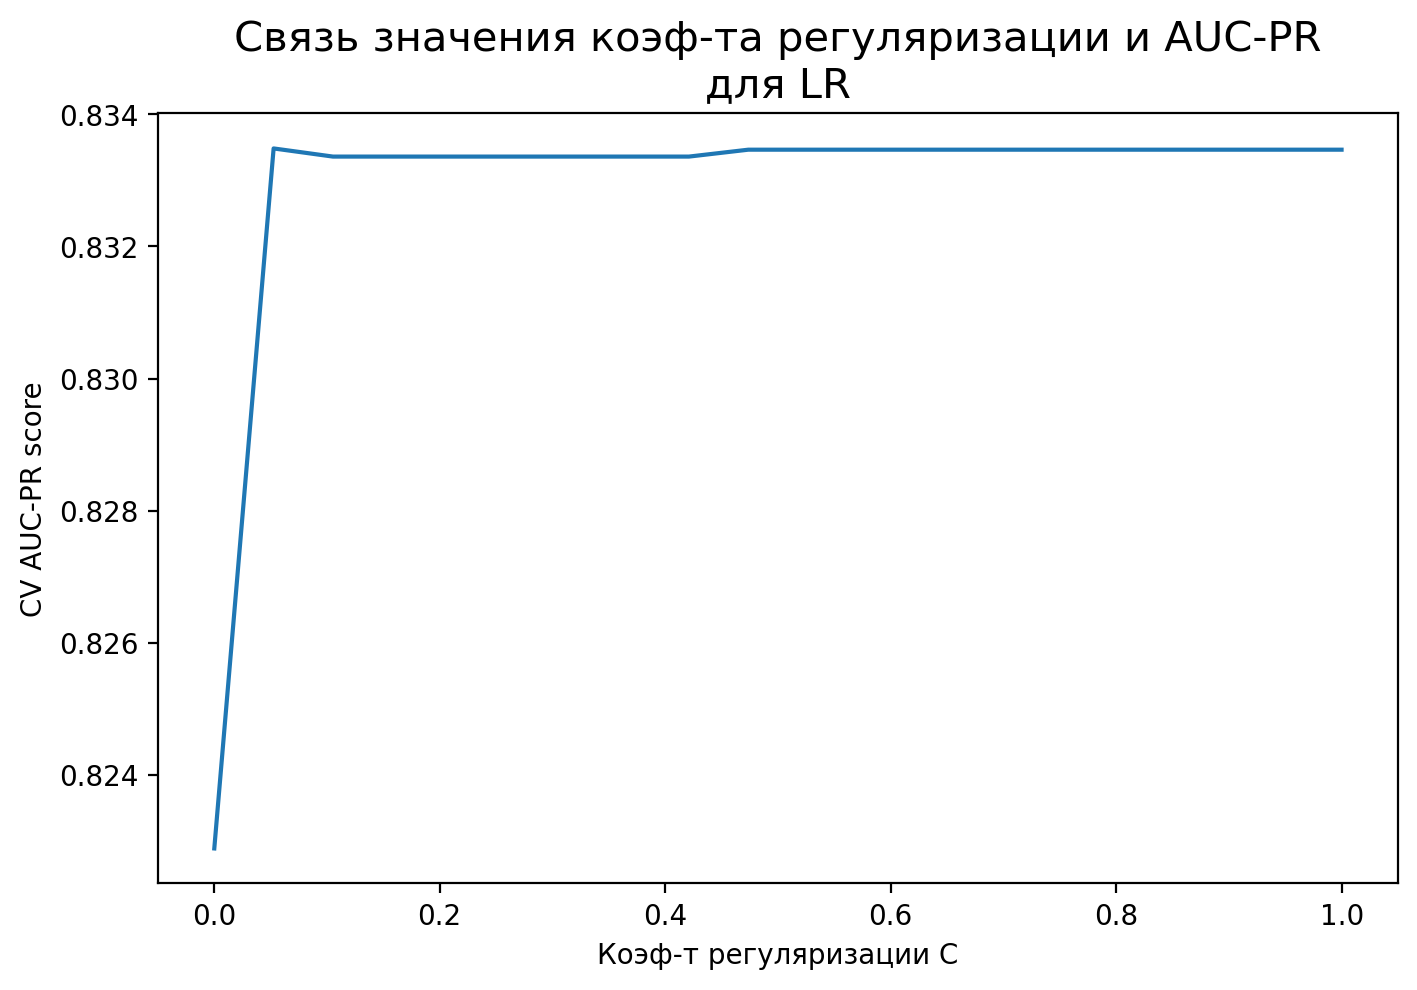

In [16]:
plt.plot(coefs_C, searcher_lr.cv_results_["mean_test_score"])
plt.title('Связь значения коэф-та регуляризации и AUC-PR\nдля LR', fontsize=15)
plt.xlabel("Коэф-т регуляризации C")
plt.ylabel("CV AUC-PR score");

In [17]:
lr = LogisticRegression(max_iter=100000, random_state=13, C=best_C_lr).fit(X_train, y_train)
y_pred_lr = lr.decision_function(X_test)

AUC-PR: 0.82928
AUC-ROC: 0.84783


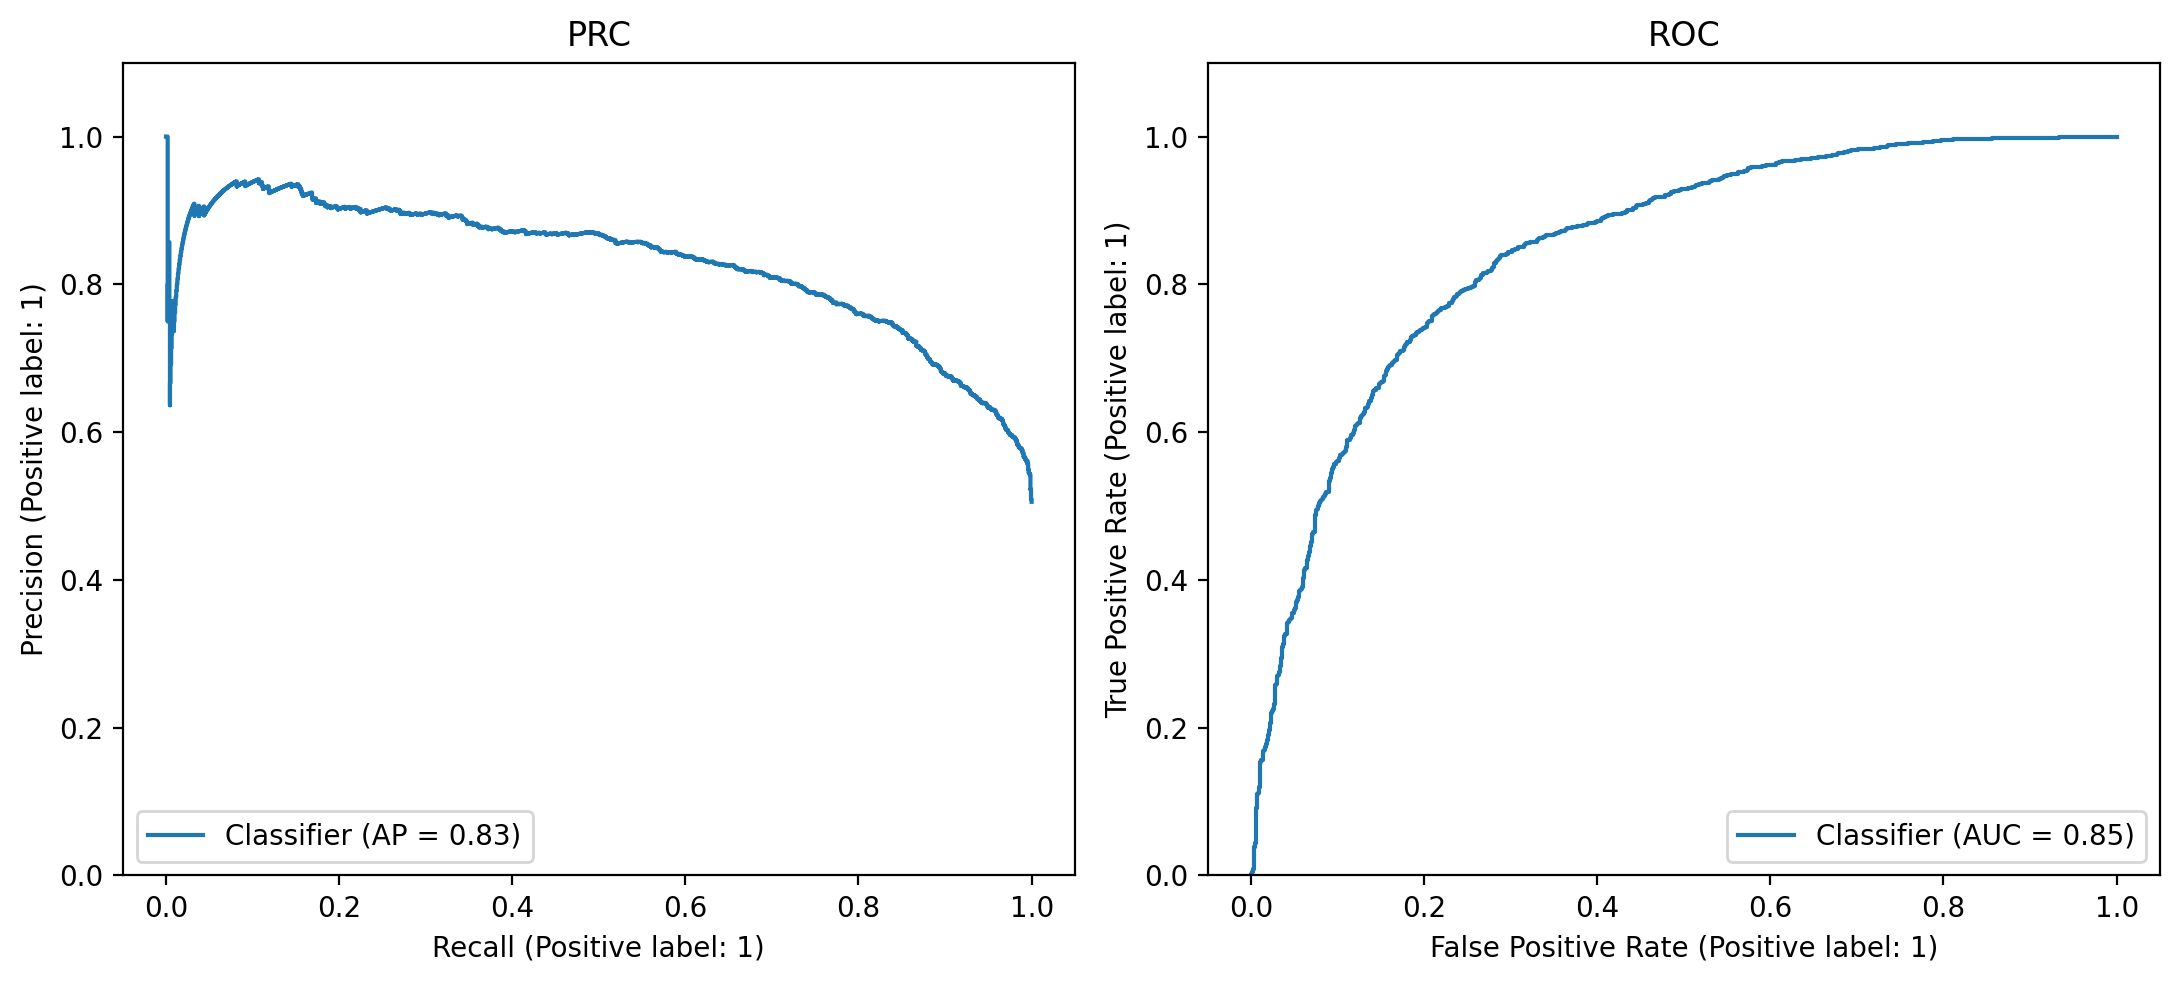

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_pred_lr, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_pred_lr)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_pred_lr, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_pred_lr))
ax[1].set_title("ROC")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [19]:
# добавление LR
df_metrics.loc['LR Classifier'] = [
    auc_pr(y_test, y_pred_lr),
    roc_auc_score(y_test, y_pred_lr),
    best_C_lr
]

In [20]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
SVM Classifier,0.829681,0.847647,0.052726
LR Classifier,0.829282,0.847826,0.052726


__Микровывод__

  Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

  Ответ: результаты получились практически идентичными, разница заметна лишь на 4-м знаке после запятой. Получилось, что значение `AUC_PR` немного больше у SVM, а `AUC_ROC` - у LR. "Классически" считается, что SVM дает лучшие значения "классификационных мер" (AUC_PR, AUC_ROC), а LR - лучше предсказывает вероятности. Сейчас получилось так, что LR дала большее значение AUC_ROC, но разница не так значительна. Оптимальный коэффициент регуляризации `C` получился  одинаковым для обоих методов.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

1) Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет.

2) Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). 

In [21]:
# генерируем данные
# беру относительно немного объектов, чтобы картинка была не сильно зашумленная
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

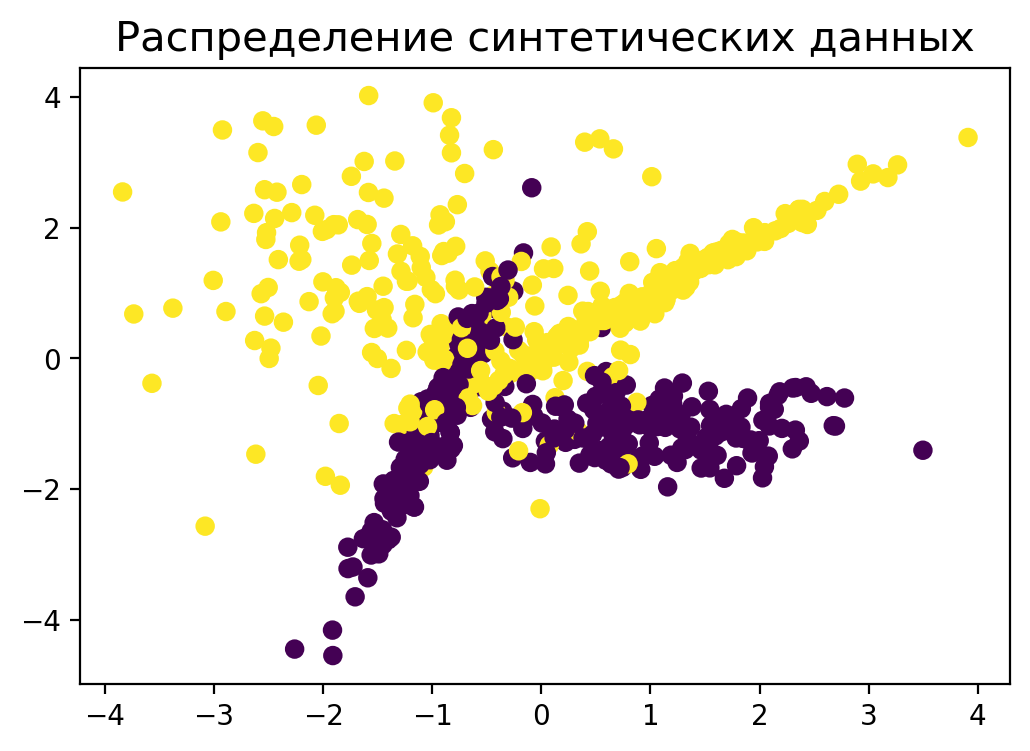

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Распределение синтетических данных', fontsize=15)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train);

В начале я визуализирую разделяющую прямую автоматически с помощью модуля `mlxtend`, а затем - вручную, чтобы отразить опорные векторы:

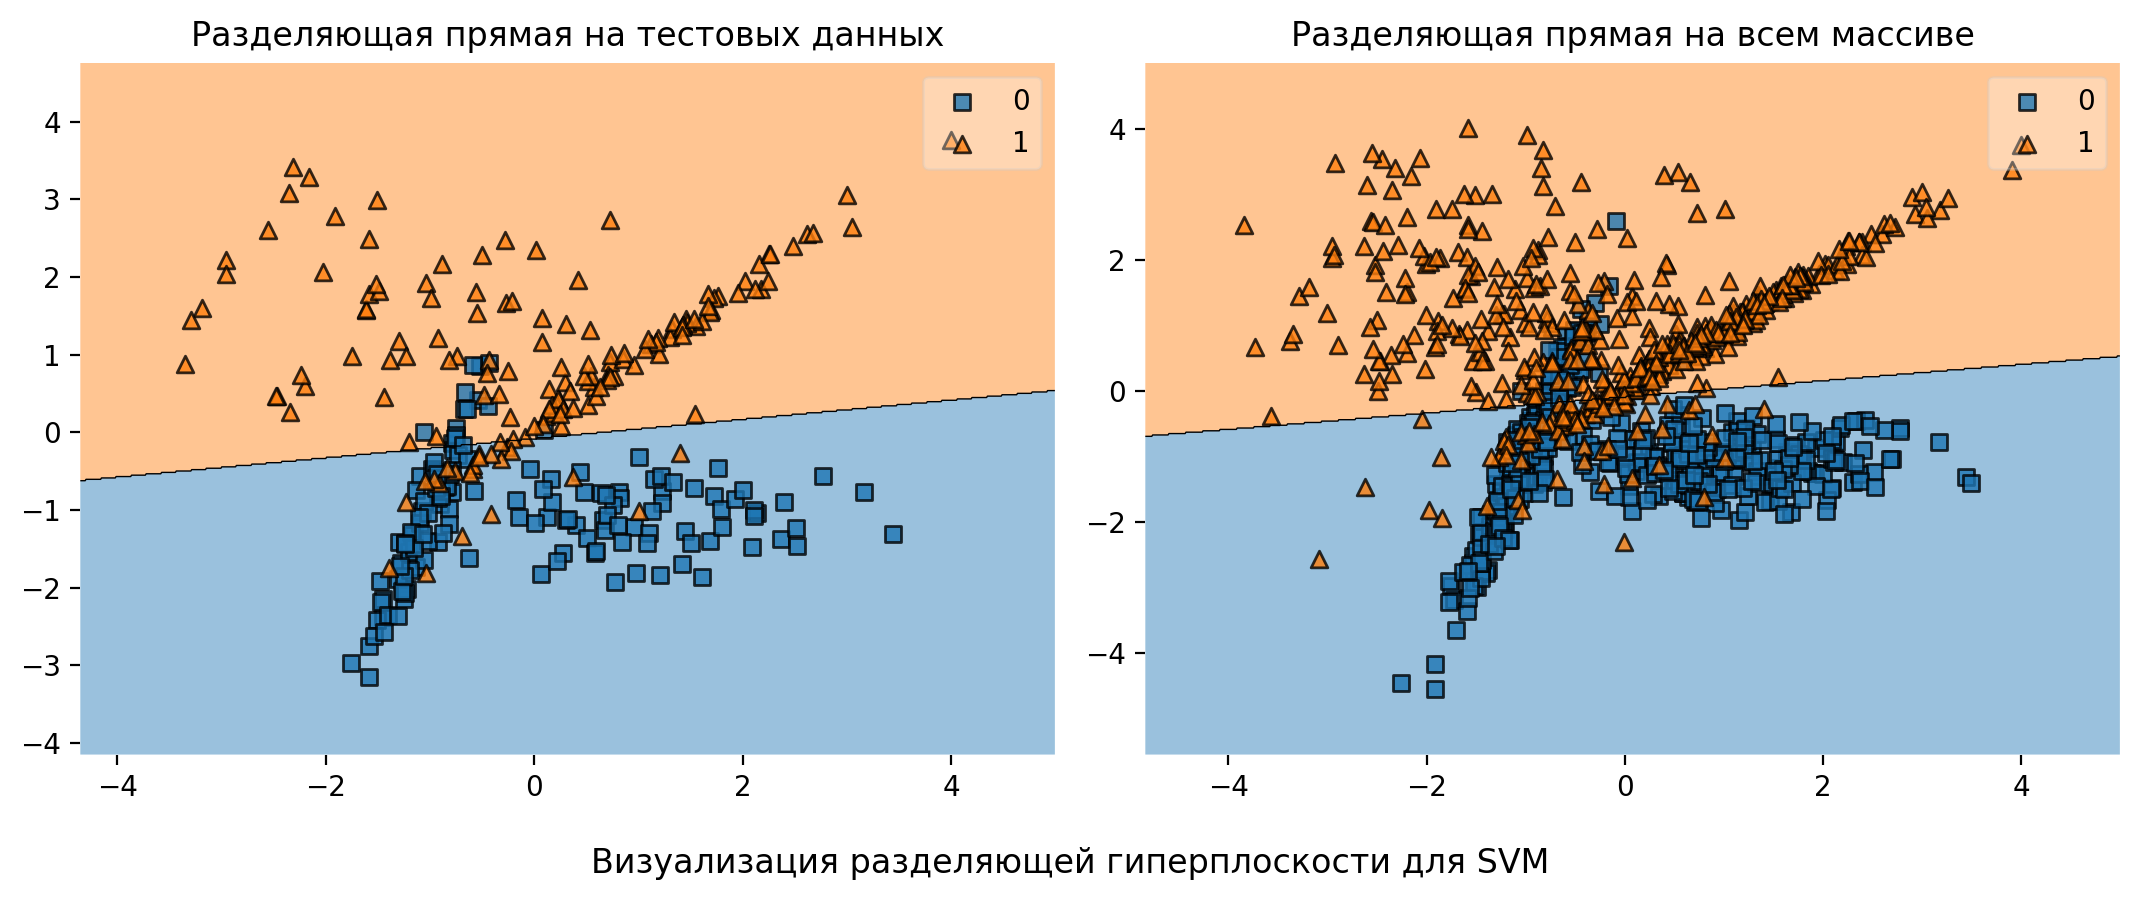

In [23]:
# источник: https://predictivehacks.com/decision-boundary-in-python/

# обучаем SVM
svc = SVC(kernel='linear', C=best_C_svm, random_state=13).fit(X_train, y_train)

# визуализируем
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

plot_decision_regions(X_test, y_test, svc, ax=axs[0])
axs[0].set_title('Разделяющая прямая на тестовых данных')

plot_decision_regions(X, y, svc, ax=axs[1])
axs[1].set_title('Разделяющая прямая на всем массиве')

fig.suptitle('Визуализация разделяющей гиперплоскости для SVM', y=0.035)
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

Далее самостоятельная реализация:

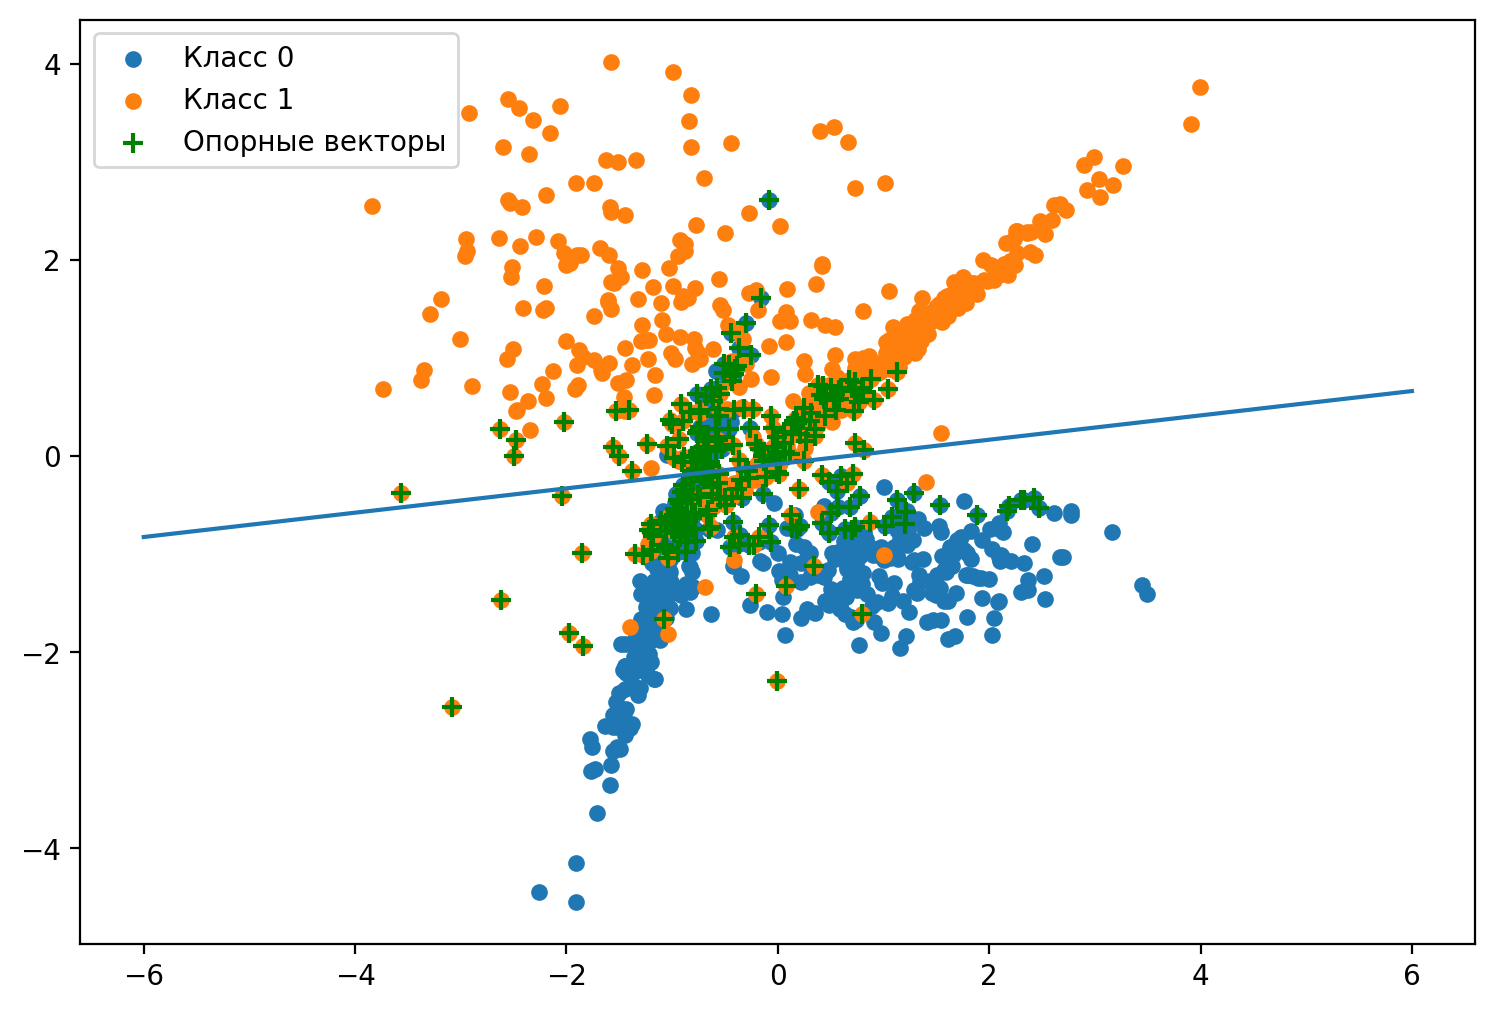

In [24]:
stacked_data = np.column_stack((X, y))
data_0 = []
data_1 = []

for i, a in enumerate(stacked_data[:,2]):
    if a == 0:
        data_0.append(stacked_data[i,:])
    else:
        data_1.append(stacked_data[i,:])

data_0 = np.array(data_0)
data_1 = np.array(data_1)

# считаем гиперплоскость
w_1 = svc.coef_[0][0]
w_2 = svc.coef_[0][1]
w_0 = svc.intercept_[0]
support_vectors = svc.support_vectors_
x_space = np.linspace(-6, 6)

# рисуем график

plt.figure(figsize=(9, 6))
plt.scatter(data_0[:, 0], data_0[:, 1], s=25)
plt.scatter(data_1[:, 0], data_1[:, 1], s=25)
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], marker = '+', s = 50, color = 'green')
plt.plot(x_space, -(w_0 + w_1 * x_space) / w_2)
plt.legend(['Класс 0', 'Класс 1', 'Опорные векторы'])
plt.show()

Видно, что опорными векторами являются практически все объекты, находящиеся вблизи разделяющей гиперплоскости, а также большинство неправильно классифицированных объектов.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor` ([matplotlib demo](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/pcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-pcolor-demo-py)).

In [25]:
# источник: https://matplotlib.org/stable/gallery/images_contours_and_fields/pcolor_demo.html
# подготовка данных

lr = LogisticRegression(max_iter=100000, random_state=13, C=best_C_lr).fit(X_train, y_train)

dx, dy = 0.15, 0.05
y, x = np.mgrid[-5:5+dy:dy, -5:5+dx:dx]

z = np.array([]).reshape(-1, 2)
for i in range(len(x)):
    new_col = np.column_stack((x[i].reshape(-1, 1), y[i].reshape(-1, 1)))
    z = np.concatenate((z, new_col), axis=0)

y_pred_z = lr.predict_proba(z)[:, 0]
y_pred_z = y_pred_z.reshape((201, 68))
z_min, z_max = y_pred_z.min(), y_pred_z.max()

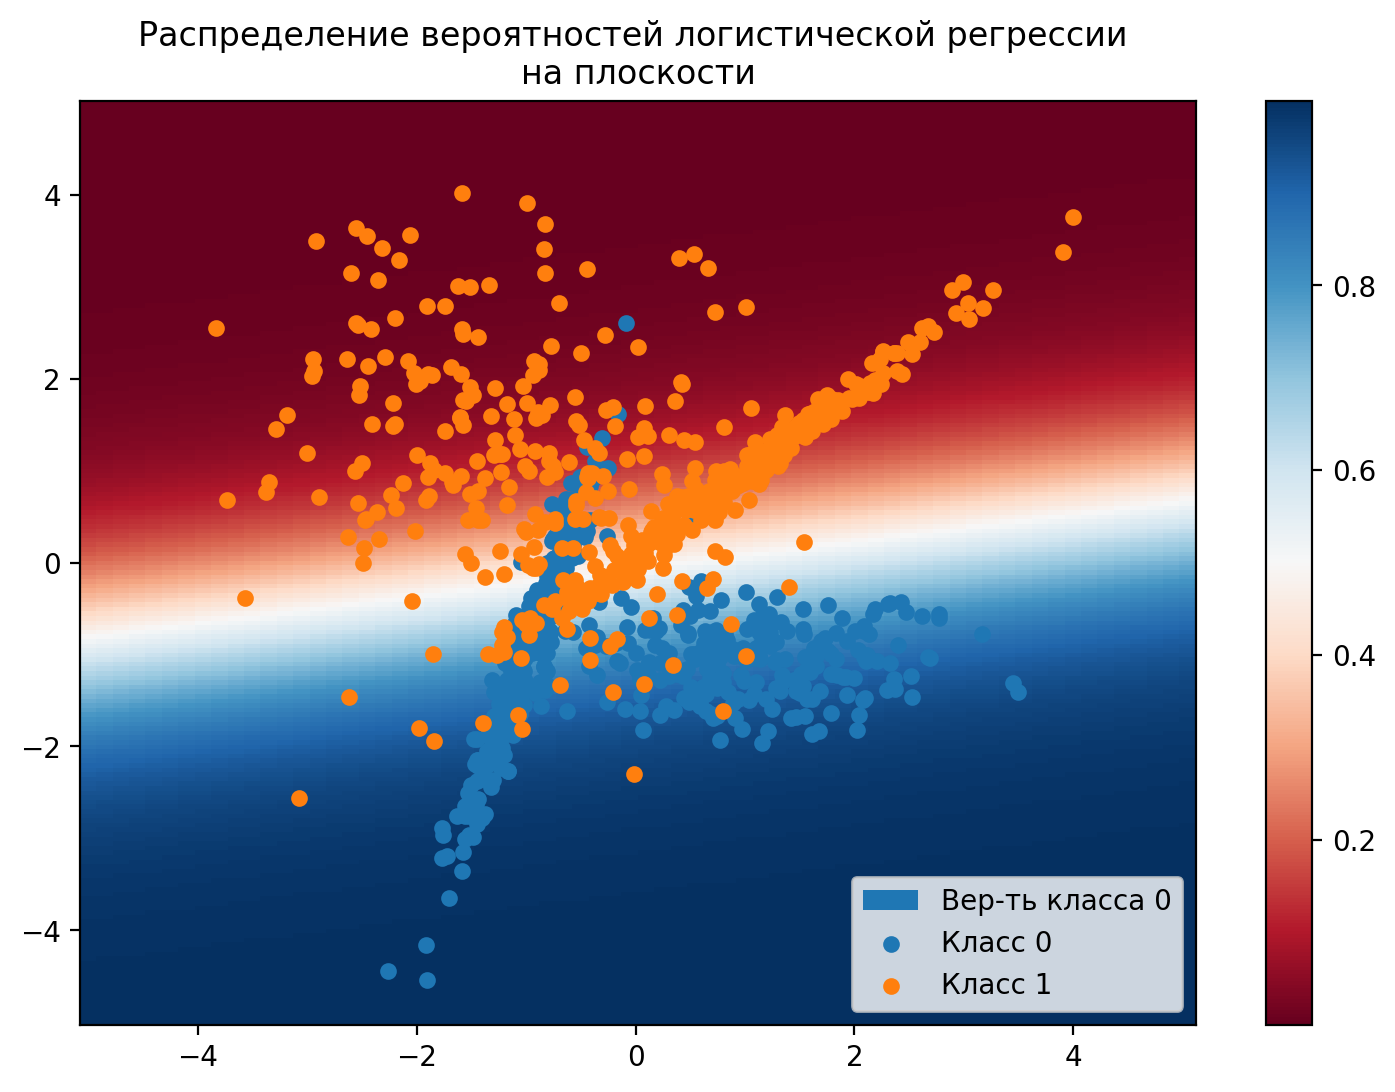

In [26]:
# график
fig, ax = plt.subplots(figsize=(9, 6))

c = ax.pcolor(x, y, y_pred_z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Распределение вероятностей логистической регрессии \nна плоскости')
plt.scatter(data_0[:, 0], data_0[:, 1], s=25)
plt.scatter(data_1[:, 0], data_1[:, 1], s=25)
plt.legend(['Вер-ть класса 0', 'Класс 0', 'Класс 1'])
fig.colorbar(c, ax=ax);

В данном случае, чем больше темнее синий цвет - тем больше вероятность того, что в данной области находится объект класса 0 (голубой). Чтобы получить вероятности для класса 1, нужно взять другой столбец в `lr.predict_proba(z)[:, 0]`.

#### __Задание 2. Калибровка вероятностей__ (1 балл)

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [27]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

*Были исправлены разность координат на сумму координат, а также взятие среднего вместо минимального значения.*

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

In [28]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

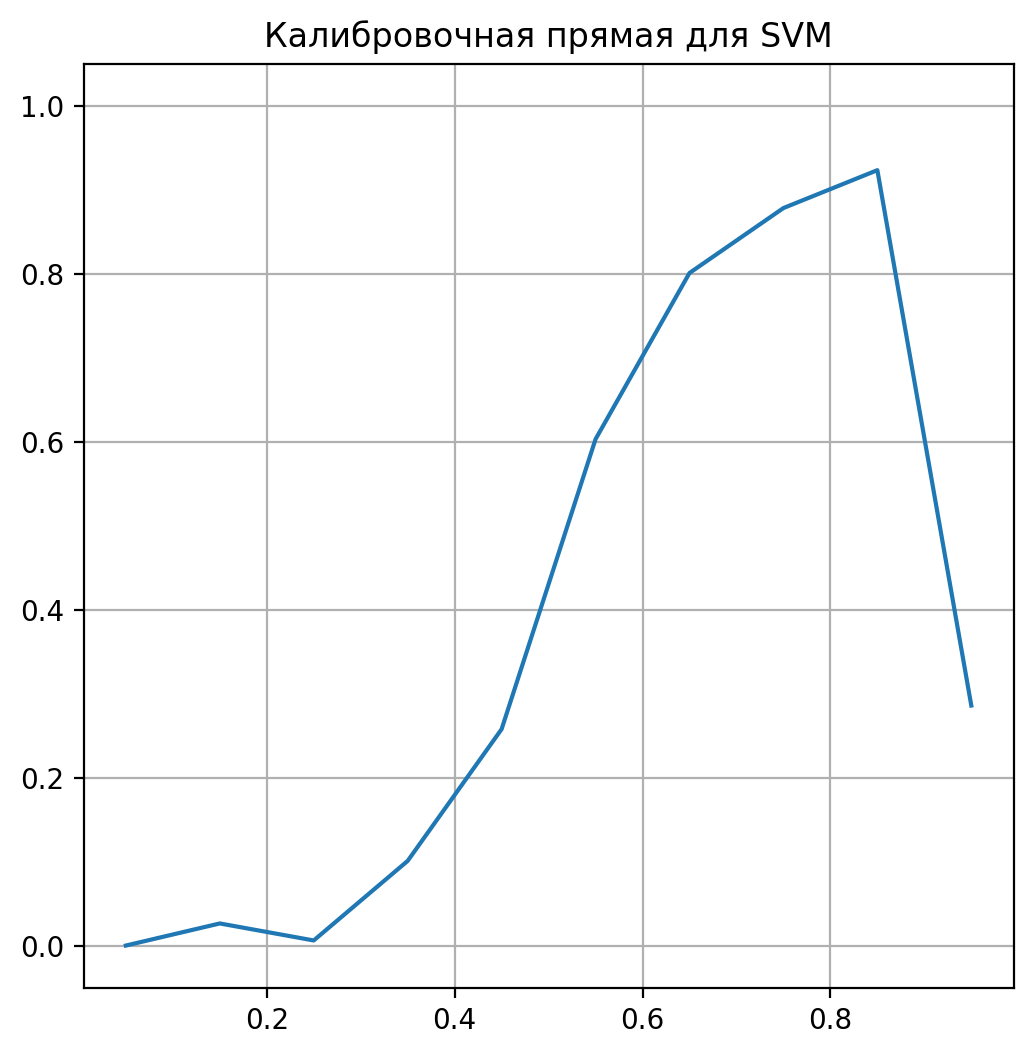

In [29]:
svc = SVC(kernel='linear', C=best_C_svm, random_state=13).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)

svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())

plot_calibration_curve(y_test, svc_pred)
plt.title('Калибровочная прямая для SVM');

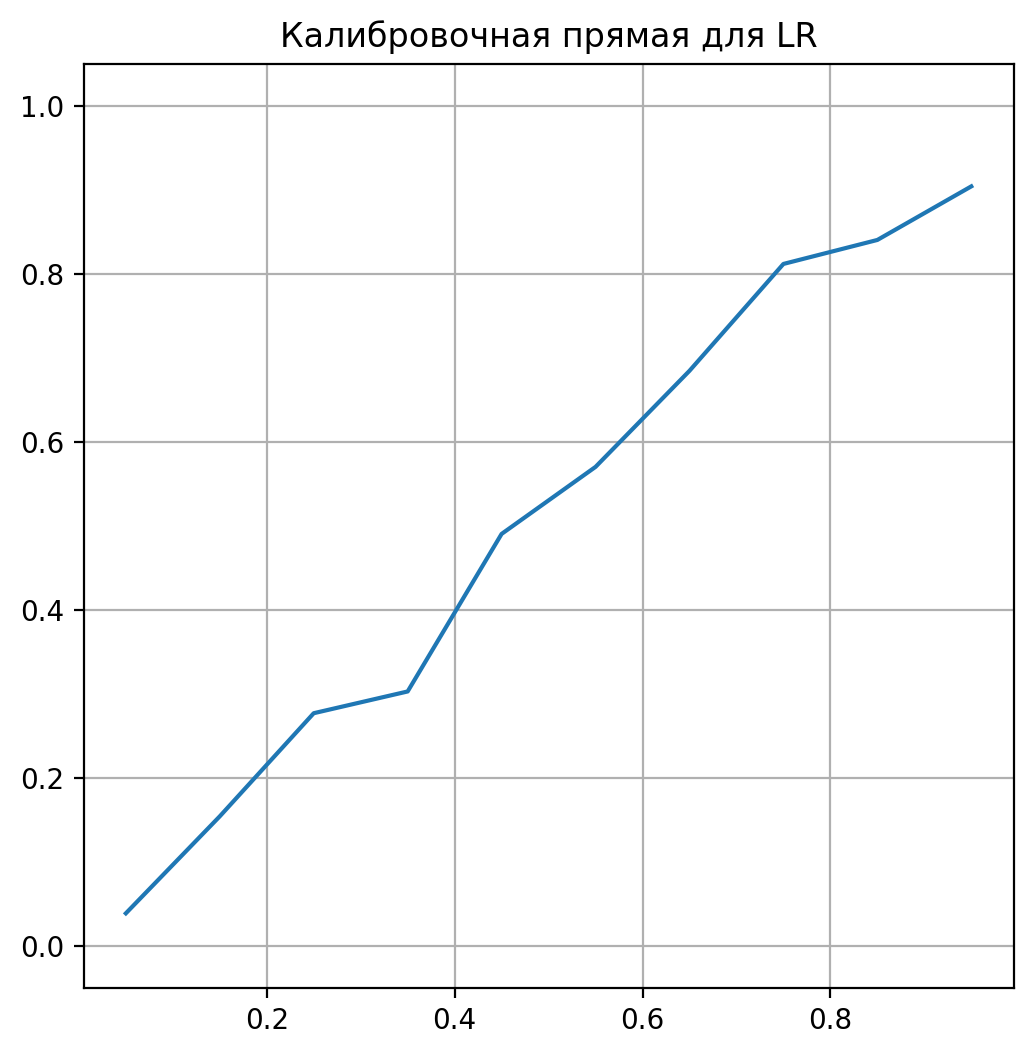

In [30]:
lr = LogisticRegression(max_iter=100000, random_state=13, C=best_C_lr).fit(X_train, y_train)

lr_pred = lr.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, lr_pred)
plt.title('Калибровочная прямая для LR');

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

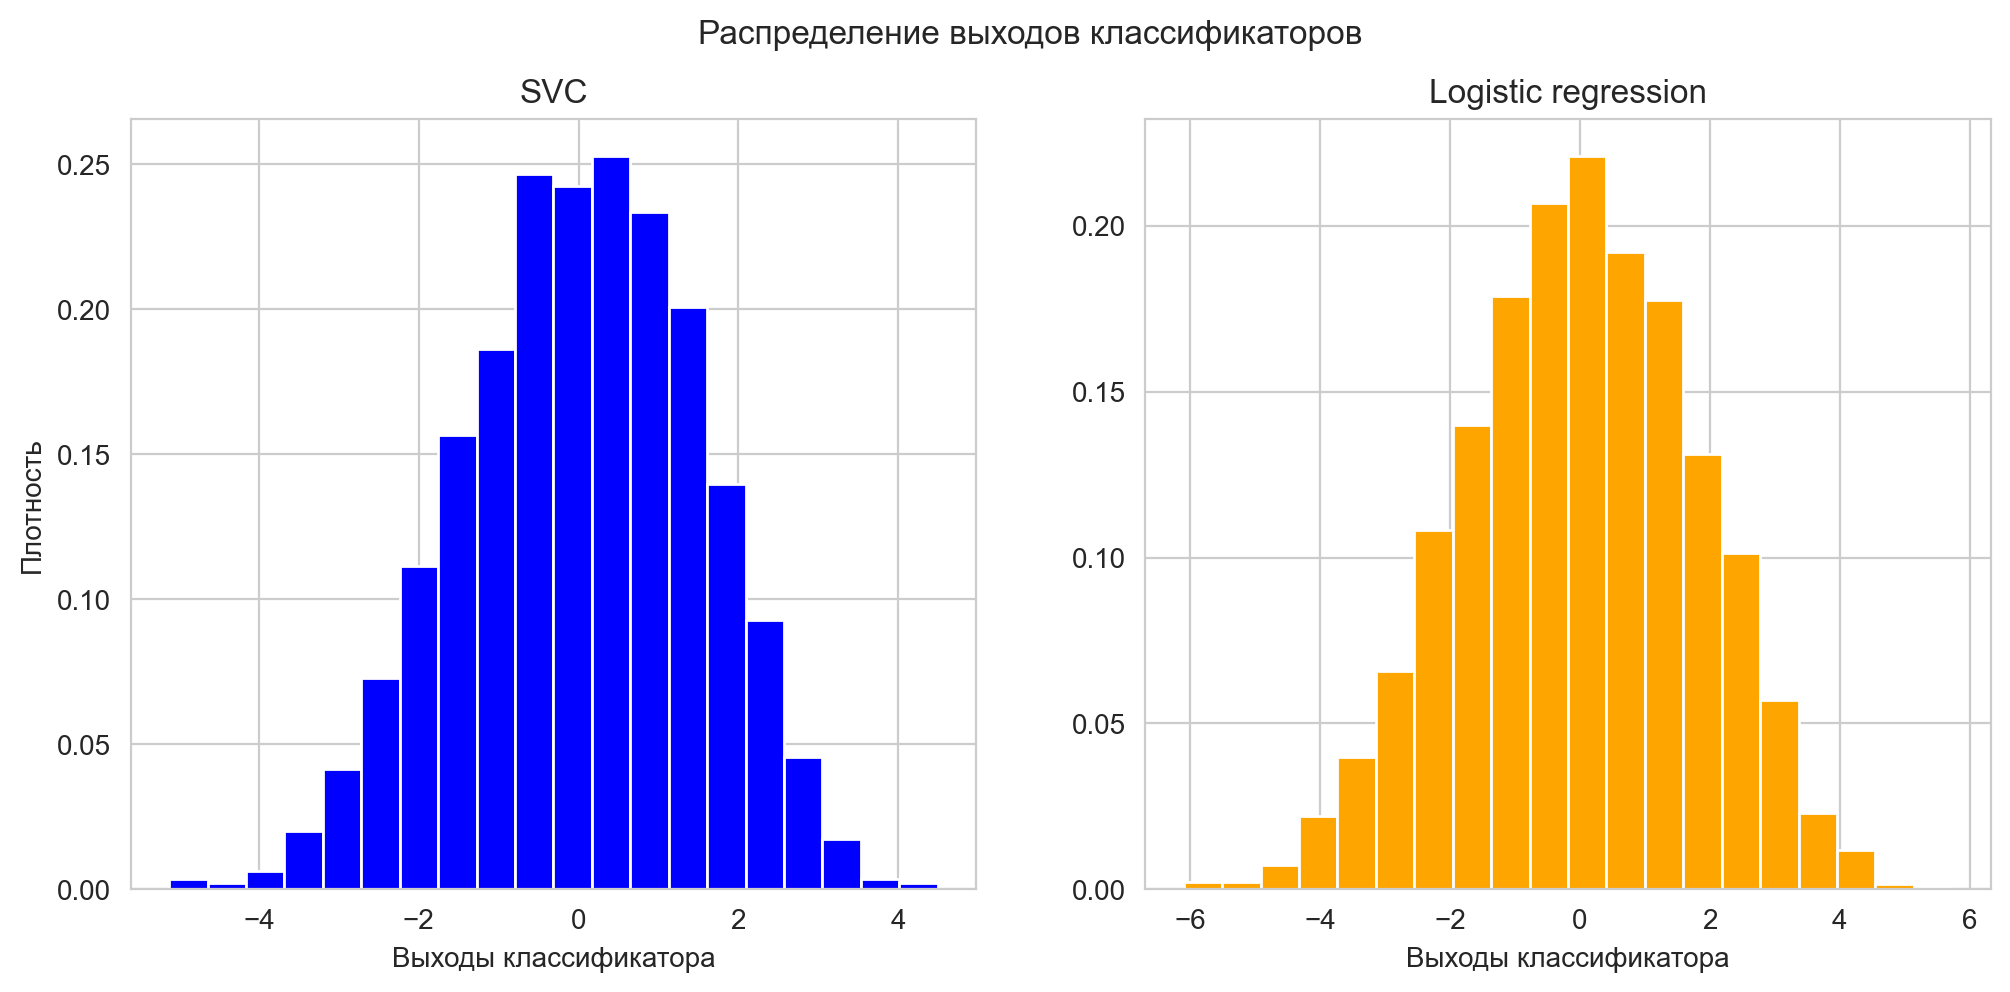

In [31]:
# код из семинара 6

svc_pred = svc.decision_function(X_test)
lr_pred = lr.decision_function(X_test)

sns.set_style('whitegrid')

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(lr_pred, bins=20, color='orange', density='True')

axs[0].set_xlabel('Выходы классификатора')
axs[1].set_xlabel('Выходы классификатора')

axs[0].set_ylabel('Плотность')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Распределение выходов классификаторов');

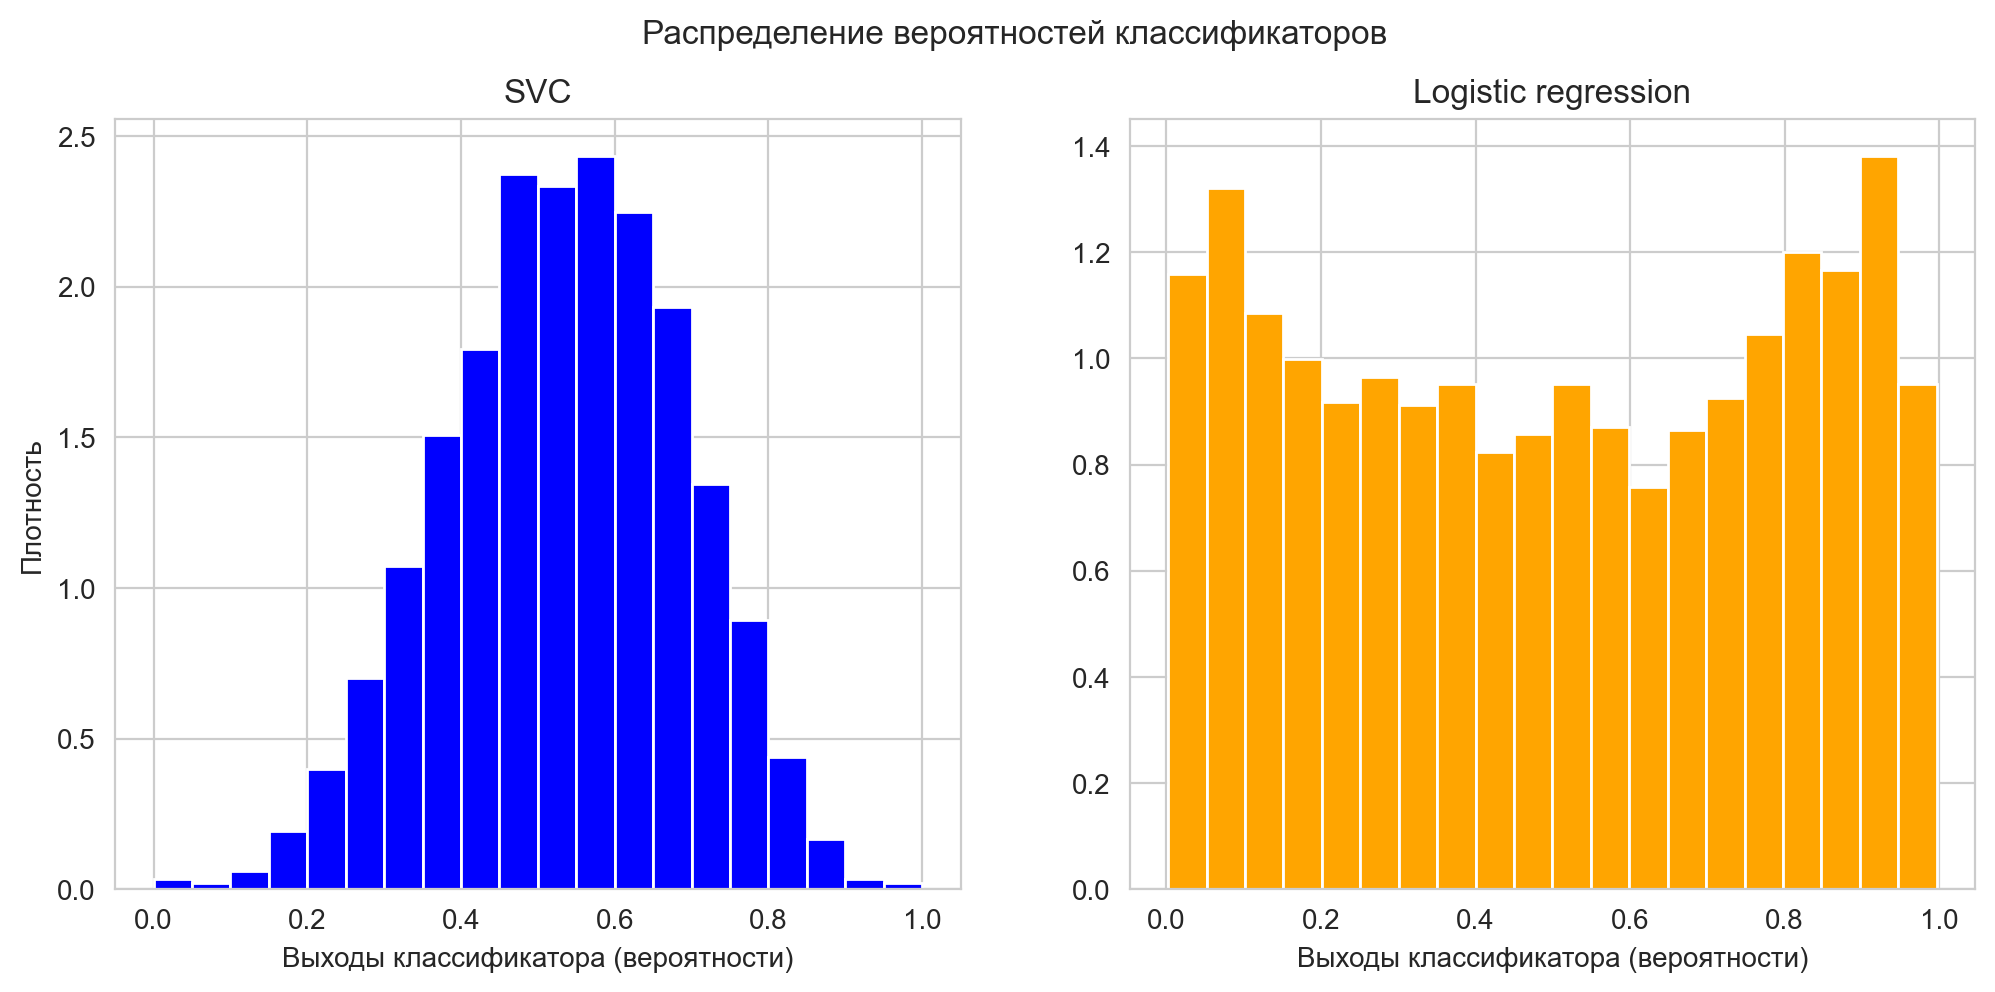

In [33]:
# код из семинара 6

svc_pred = svc.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
lr_pred = lr.predict_proba(X_test)[:, 1]

sns.set_style('whitegrid')

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(lr_pred, bins=20, color='orange', density='True')

axs[0].set_xlabel('Выходы классификатора (вероятности)')
axs[1].set_xlabel('Выходы классификатора (вероятности)')

axs[0].set_ylabel('Плотность')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Распределение вероятностей классификаторов');

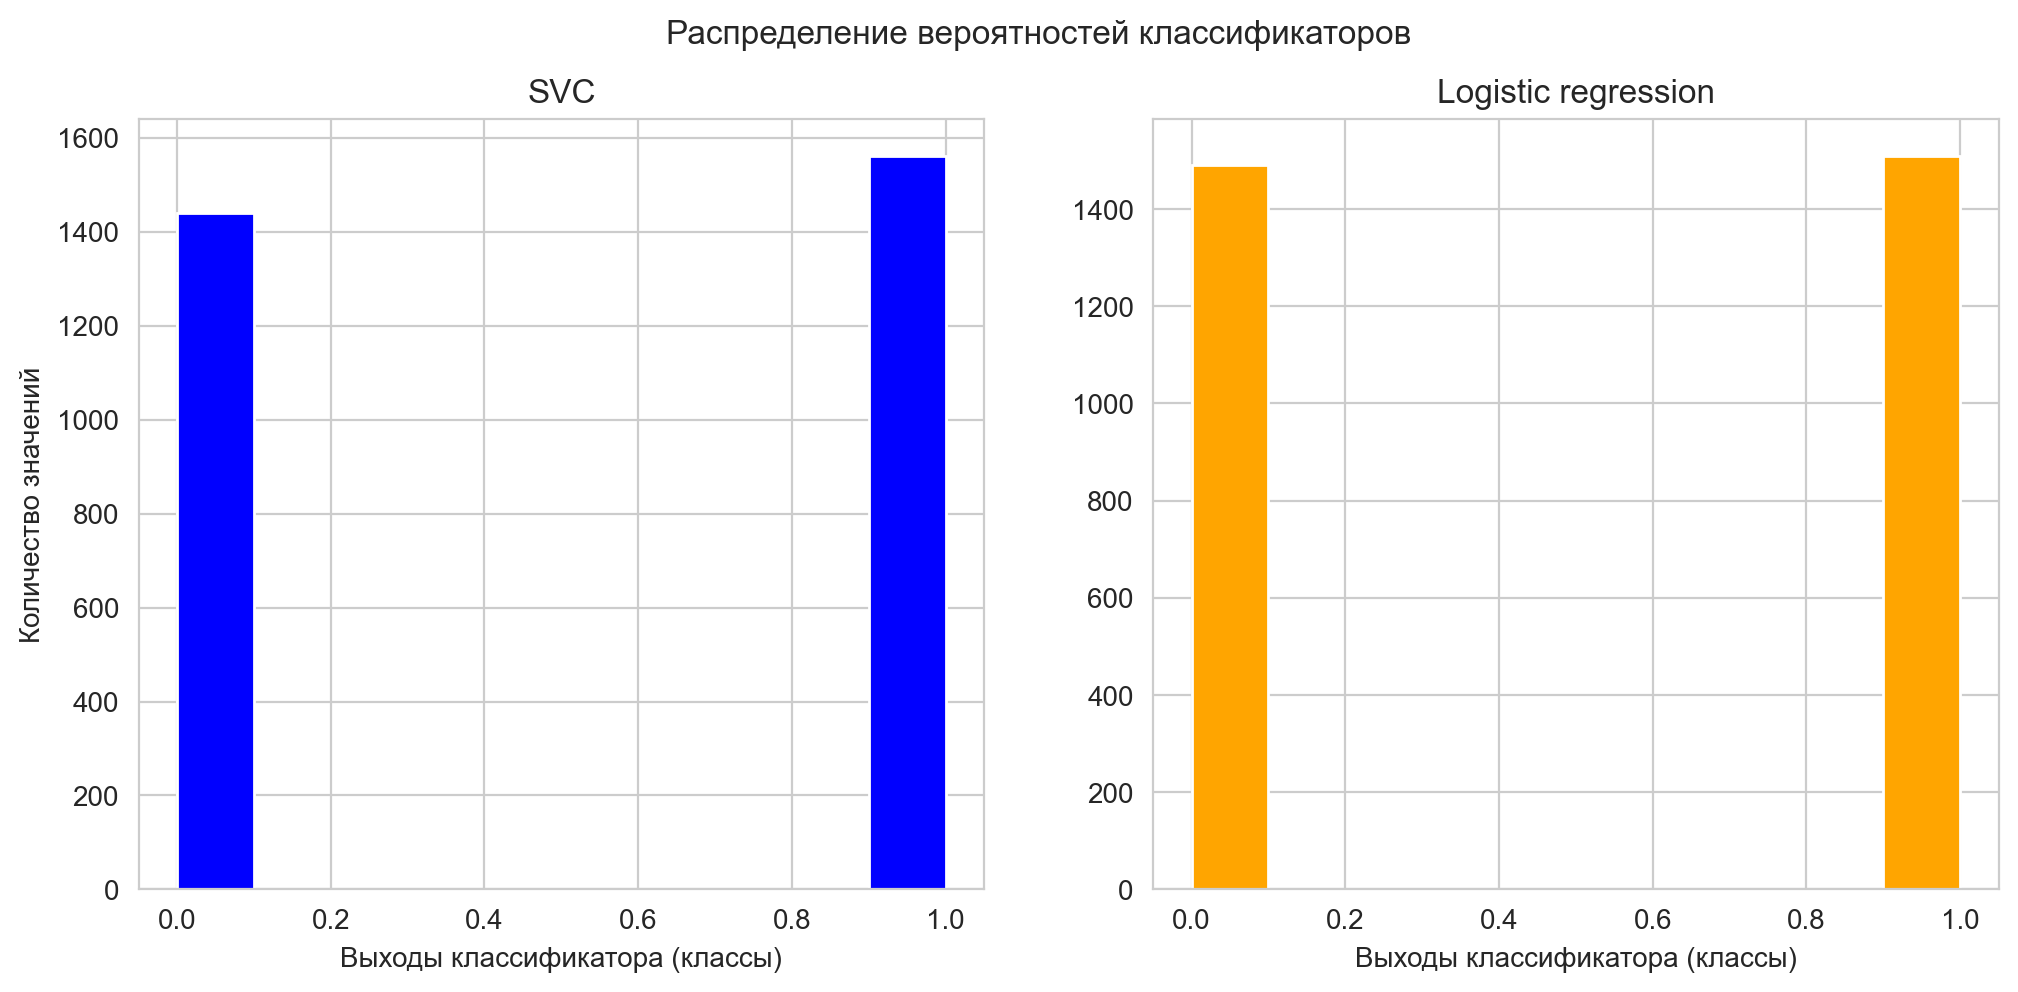

In [34]:
y_pred_svc = svc.predict(X_test)
y_pred_lr = lr.predict(X_test)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(y_pred_svc, color='blue')
axs[1].hist(y_pred_lr, color='orange')

axs[0].set_xlabel('Выходы классификатора (классы)')
axs[1].set_xlabel('Выходы классификатора (классы)')

axs[0].set_ylabel('Количество значений')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Распределение вероятностей классификаторов');

Чем они различаются? Чем вы можете объяснить это?

**Ответ**: чистые выходы обеих моделей похожи на нормальное распределение. Но вот распределение вероятностей у SVM также *нормальное*, а у LR - тяготеет к *равномерному* распределению, причем "хвосты" с обоих концов больше, чем в середине - это показывает, что LR максимизирует вероятность классов в конкретной точке - логично, что она больше уверена, если объект далеко от разделяющей гиперплоскости, чем если непосредственно рядом с ней (там она "сомневается"). Также интересно, что распределение классов (т.е. значений 0 или 1) у LR также более равномерное, чем у SVM.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [35]:
# калибровка и подготовка данных

calibration_svc = CalibratedClassifierCV(SVC(kernel='linear'), method='sigmoid', cv=10)
calibration_svc.fit(X_train, y_train)
svc_pred_calibrated = calibration_svc.predict_proba(X_test)[:,1]
svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred_calibrated, n_bins=10)

# некалиброванный вариант для сравнения
svc = SVC(kernel='linear', C=best_C_svm, random_state=13).fit(X_train, y_train)
svc_pred_not_calib = svc.decision_function(X_test)
svc_pred_not_calib = (svc_pred_not_calib - svc_pred_not_calib.min()) / (svc_pred_not_calib.max() - svc_pred_not_calib.min())
svc_true_not_prob, svc_pred_not_prob = calibration_curve(y_test, svc_pred_not_calib, n_bins=10)

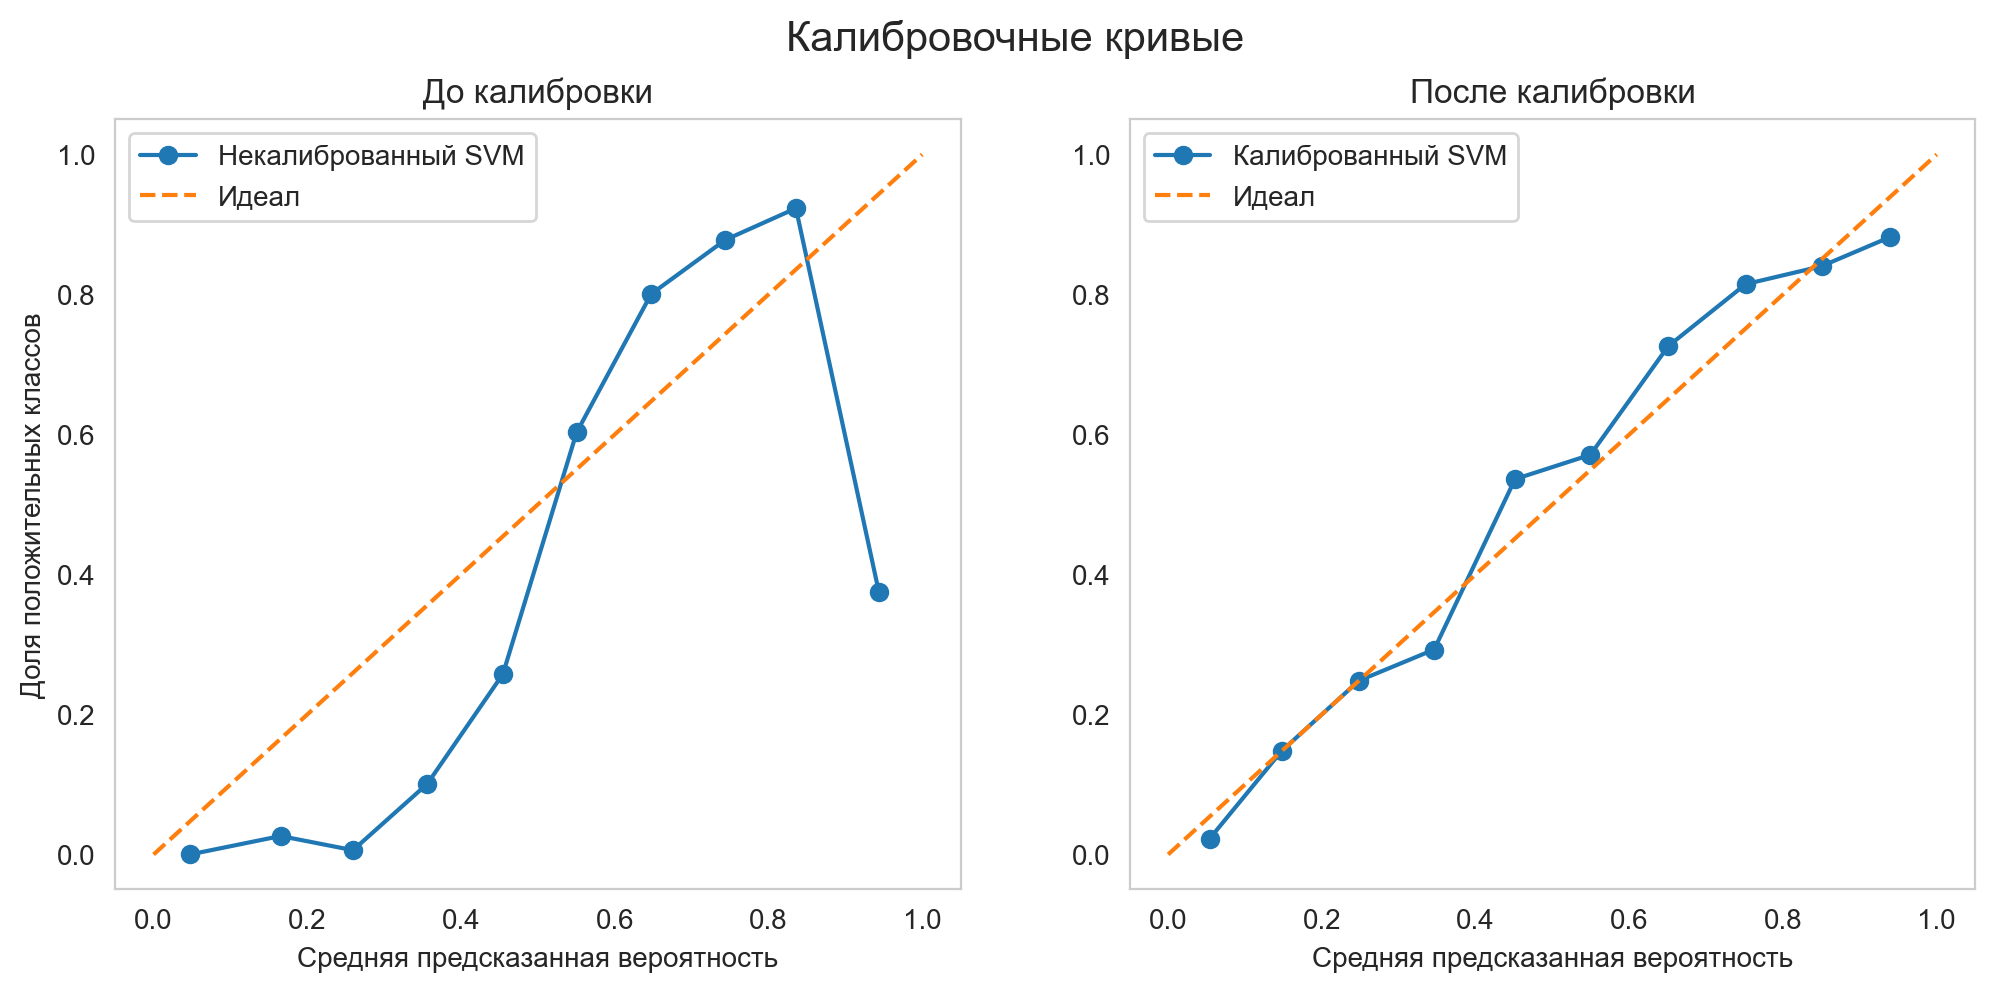

In [36]:
# график

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.set_style('whitegrid')

axs[0].grid()
axs[0].plot(svc_pred_not_prob, svc_true_not_prob, 'o-', label='Некалиброванный SVM')
axs[0].plot([0, 1], [0, 1], '--', label='Идеал')
axs[0].set_xlabel('Средняя предсказанная вероятность')
axs[0].set_ylabel('Доля положительных классов')
axs[0].set_title('До калибровки')
axs[0].legend()

axs[1].grid()
axs[1].plot(svc_pred_prob, svc_true_prob, 'o-', label='Калиброванный SVM')
axs[1].plot([0, 1], [0, 1], '--', label='Идеал')
axs[1].set_xlabel('Средняя предсказанная вероятность')
axs[1].set_ylabel('')
axs[1].set_title('После калибровки')
axs[1].legend()

plt.suptitle('Калибровочные кривые', fontsize=15);

*Как видно, кривая калиброванного SVM очень хорошо аппроксимирует идеальную прямую!*

# Часть 2. Обработка категориальных переменных

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла. 

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет. 

In [61]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data # doesnt work locally but works in collab

import wget 
wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 'adult.data')  # works locally

'adult.data'

In [37]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [38]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [39]:
df.shape

(32561, 15)

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.income, test_size=0.25, stratify=df.income, random_state=777)

In [41]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24420, 14), (24420,), (8141, 14), (8141,))

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`, а числовые признаки нормализуйте с помощью `StandardScaler`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [42]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time

In [43]:
categorical_features = list(X_train.dtypes[X_train.dtypes == "object"].index)
numeric_features = list(X_train.dtypes[X_train.dtypes == "int64"].index)

column_transformer = ColumnTransformer([
    ('ord', OrdinalEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ord_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000, random_state=13))
])

In [44]:
np.random.seed(13)

start_time1 = time.process_time()                   # замеряем процессорное время
start_time2 = time.perf_counter()                   # замеряем обычное время
model = pipeline.fit(X_train, y_train)
finish_time1 = time.process_time()
finish_time2 = time.perf_counter()

delta_time_process = finish_time1 - start_time1
delta_time_counter = finish_time2 - start_time2

y_pred = model.decision_function(X_test)

auc_pr_lr = auc_pr(y_test, y_pred)

print(f'Качество (AUC-PR) составило: {round(auc_pr_lr, 5)}')
print(f'Процессорное время составило: {round(delta_time_process, 5)} сек.')
print(f'Классическое время составило: {round(delta_time_counter, 5)} сек.')

Качество (AUC-PR) составило: 0.68222
Процессорное время составило: 1.20312 сек.
Классическое время составило: 0.37182 сек.


__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ответ__: мы работаем с социально-экономическими данными, в которых, вероятно, важнее не сам факт правильной классификации, а то, насколько высокая точность наших предсказаний и охват всего положительного класса. Можно сказать, что это более "бизнесовая" (маркетинговая) задача. К тому же, `AUC-PR` лучше работает с неравномерным балансом таргета: положительного класса 24%.

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [46]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000, random_state=13))
])

In [47]:
np.random.seed(13)

start_time1 = time.process_time()                   # замеряем процессорное время
start_time2 = time.perf_counter()                   # замеряем обычное время
model = pipeline.fit(X_train, y_train)
finish_time1 = time.process_time()
finish_time2 = time.perf_counter()

delta_time_process = finish_time1 - start_time1
delta_time_counter = finish_time2 - start_time2

y_pred = model.decision_function(X_test)

auc_pr_lr = auc_pr(y_test, y_pred)

print(f'Качество (AUC-PR) составило: {round(auc_pr_lr, 5)}')
print(f'Процессорное время составило: {round(delta_time_process, 5)} сек.')
print(f'Классическое время составило: {round(delta_time_counter, 5)} сек.')

Качество (AUC-PR) составило: 0.76713
Процессорное время составило: 0.64062 сек.
Классическое время составило: 0.65857 сек.


*Качество выросло на 0.85 в терминах AUC-PR, но время трансформации и обучения тоже увеличилось - примерно в два раза.*

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [48]:
def mean_target_encoding(X_train, X_test, y_train, column):
    '''
    X_train - обучающая выборка
    X_test  - тестовая выборка
    y_train - ответы для обучающей выборки
    column  - название признака для трансформации
    '''
    df_info = X_train.copy()
    df_info['y'] = y_train

    mean_enc = df_info.groupby(column)['y'].mean()
    X_train[column + '_mte'] = X_train[column].map(mean_enc)
    X_test[column + '_mte'] = X_test[column].map(mean_enc)
    X_train = X_train.drop([column], axis=1)
    X_test = X_test.drop([column], axis=1)
    return X_train, X_test

In [49]:
# оставим StandardScaler и не будем трогать mte
new_categorical_features = list(map(lambda x: x + '_mte', categorical_features))

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features),
    ('other',  'passthrough', new_categorical_features)
])

In [50]:
np.random.seed(13)

columns = categorical_features
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

start_time1 = time.process_time()                   # замеряем процессорное время
start_time2 = time.perf_counter()                   # замеряем обычное время
for column in columns:
    X_train_encoded, X_test_encoded = mean_target_encoding(X_train_encoded, X_test_encoded, y_train, column)

X_train_encoded = column_transformer.fit_transform(X_train_encoded)
X_test_encoded = column_transformer.transform(X_test_encoded)

lr_mte = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_encoded, y_train)
finish_time1 = time.process_time()
finish_time2 = time.perf_counter()

delta_time_process = finish_time1 - start_time1
delta_time_counter = finish_time2 - start_time2

y_pred_lr = lr_mte.decision_function(X_test_encoded)
auc_pr_lr = auc_pr(y_test, y_pred_lr)

print(f'Качество на test (AUC-PR) составило: {round(auc_pr_lr, 5)}')
print(f'Процессорное время составило: {round(delta_time_process, 5)} сек.')
print(f'Классическое время составило: {round(delta_time_counter, 5)} сек.')

Качество на test (AUC-PR) составило: 0.75579
Процессорное время составило: 0.5625 сек.
Классическое время составило: 0.2339 сек.


In [51]:
y_pred_lr = lr_mte.decision_function(X_train_encoded)
auc_pr_lr = auc_pr(y_train, y_pred_lr)
print(f'Качество на train (AUC-PR) составило: {round(auc_pr_lr, 5)}')

Качество на train (AUC-PR) составило: 0.76016


Время кодирования и обучения снизилось даже по сравнению с `OrdinalEncoder`, но качество снизилось на 0.01 по сравнению с `OneHotEncoder`. При этом нельзя сказать, что модель сильно переобучилась: разница между train и test 0.01.

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

Я сделаю небольшой перебор, чтобы определить лучшее значение стандартного отклонения для добавляемого шума. Это сложно назвать гиперпараметром, поэтому я не стану применять валидационную выборку, тем более что значений и так немного.

In [52]:
np.random.seed(13)

scales = np.linspace(0.01, 1, 20)
auc_prs = []

for scale_i in scales:
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    for column in columns:
        X_train_encoded, X_test_encoded = mean_target_encoding(X_train_encoded, X_test_encoded, y_train, column)

    # добавляем шум
    for column in list(map(lambda x: x + '_mte', categorical_features)):
        X_train_encoded[column] = X_train_encoded[column] + np.random.normal(loc=0, scale=scale_i, size=X_train_encoded.shape[0])
        X_test_encoded[column] = X_test_encoded[column] + np.random.normal(loc=0, scale=scale_i, size=X_test_encoded.shape[0])
    
    X_train_encoded = column_transformer.fit_transform(X_train_encoded)
    X_test_encoded = column_transformer.transform(X_test_encoded)

    lr_mte_noise = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_encoded, y_train)
    lr_noise = lr_mte_noise.decision_function(X_test_encoded)
    auc_pr_lr = auc_pr(y_test, lr_noise)

    auc_prs.append(auc_pr_lr)

In [53]:
best_idx = np.argmax(auc_prs)
print(f'Лучшее значение std: {scales[best_idx]}')
print(f'Лучшее качество на test (AUC-PR) составило: {round(auc_prs[best_idx], 5)}')

Лучшее значение std: 0.01
Лучшее качество на test (AUC-PR) составило: 0.75602


Во-первых, можно заметить, что наилучшим оказалось минимальное значение std для нормального шума: всего 0.01. Во-вторых, с помощью него удалось улучшить качество модели и приблизить метрику AUC-PR на обучающей выборке: $0.75602$ против $0.76016$ (без шума было $0.75579$).

Из этого можно сделать вывод о том, что, когда мы работаем с небольшими значениями (доли полож. классов измеряются в [0; 1]), шум должен быть небольшим. В целом, можно сказать, что размер шума всегда нужно выбирать, соотнося его с масштабом таргета.

При этом, надо отметить, что переобучение изначально было не таким большим.

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты.


In [54]:
def s_mean_target_encoding(X_train, X_test, y_train, column, C=10):
    '''
    X_train - обучающая выборка
    X_test  - тестовая выборка
    y_train - ответы для обучающей выборки
    column  - название признака для трансформации
    C       - параметр сглаживания
    '''
    df_info = X_train.copy()
    df_info['y'] = y_train
    global_mean = df_info['y'].mean()

    counts = df_info.groupby(column)['y'].count()
    means = df_info.groupby(column)['y'].mean()
    smooth = (counts * means + C * global_mean) / (counts + C)

    X_train[column+'_s_mte'] = X_train[column].map(smooth)
    X_test[column+'_s_mte'] = X_test[column].map(smooth)
    X_train = X_train.drop([column], axis=1)
    X_test = X_test.drop([column], axis=1)
    return X_train, X_test

In [55]:
# оставим StandardScaler и не будем трогать mte
new_s_categorical_features = list(map(lambda x: x + '_s_mte', categorical_features))

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features),
    ('other',  'passthrough', new_s_categorical_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000, random_state=13))
])

In [56]:
np.random.seed(13)

columns = categorical_features
X_train_s_encoded = X_train.copy()
X_test_s_encoded = X_test.copy()

start_time1 = time.process_time()                   # замеряем процессорное время
start_time2 = time.perf_counter()                   # замеряем обычное время
for column in columns:
    X_train_s_encoded, X_test_s_encoded = s_mean_target_encoding(X_train_s_encoded, X_test_s_encoded, y_train, column)

model = pipeline.fit(X_train_s_encoded, y_train)
finish_time1 = time.process_time()
finish_time2 = time.perf_counter()

delta_time_process = finish_time1 - start_time1
delta_time_counter = finish_time2 - start_time2

y_pred_s_mte = model.decision_function(X_test_s_encoded)
auc_pr_lr = auc_pr(y_test, y_pred_s_mte)

print(f'Качество на test (AUC-PR) составило: {round(auc_pr_lr, 5)}')
print(f'Процессорное время составило: {round(delta_time_process, 5)} сек.')
print(f'Классическое время составило: {round(delta_time_counter, 5)} сек.')

Качество на test (AUC-PR) составило: 0.75592
Процессорное время составило: 0.75 сек.
Классическое время составило: 0.2829 сек.


In [57]:
y_pred_s_mte = model.decision_function(X_train_s_encoded)
auc_pr_lr = auc_pr(y_train, y_pred_s_mte)
print(f'Качество на train (AUC-PR) составило: {round(auc_pr_lr, 5)}')

Качество на train (AUC-PR) составило: 0.76003


После применения сглаживания качество немного выросло по сравнению с изначальным вариантом mean-target-encoding (без шума): $0.75592$ против $0.75579$ на тесте, но это все еще меньше mean-target-encoding с шумом: $0.75602$. И также меньше, чем one-hot-encoding ($0.76713$). По времени получилось немного меньше, чем у обычного mean-target-encoding.

#### __Задание 8. И все-таки числовой?__  (0.5 балла)

В данных имеются признаки "возраст" и "число рабочих часов в неделю". Сейчас мы интерпретируем их как числовые, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?



In [58]:
print('Число уникальных значений признака "возраст":', df['age'].nunique())
print('Число уникальных значений признака "число рабочих часов в неделю":', df['hours-per-week'].nunique())

Число уникальных значений признака "возраст": 73
Число уникальных значений признака "число рабочих часов в неделю": 94


In [59]:
new_numeric_features = numeric_features[:]
new_categorical_features = categorical_features[:]

new_numeric_features.remove('age')
new_categorical_features.append('age')

# проверка
new_numeric_features, new_categorical_features, len(new_numeric_features)+len(new_categorical_features)

(['fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'],
 ['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native-country',
  'age'],
 14)

In [60]:
# оставим StandardScaler и не будем трогать mte
new_s_categorical_features = list(map(lambda x: x + '_s_mte', new_categorical_features))

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), new_numeric_features),
    ('other',  'passthrough', new_s_categorical_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000, random_state=13))
])

In [61]:
np.random.seed(13)

columns = new_categorical_features
X_train_s_encoded = X_train.copy()
X_test_s_encoded = X_test.copy()
y_train_new = y_train[:]
y_test_new = y_test[:]

start_time1 = time.process_time()                   # замеряем процессорное время
start_time2 = time.perf_counter()                   # замеряем обычное время
for column in columns:
    X_train_s_encoded, X_test_s_encoded = s_mean_target_encoding(X_train_s_encoded, X_test_s_encoded, y_train_new, column)

X_test_s_encoded = X_test_s_encoded.dropna()
y_test_new = y_test_new[X_test_s_encoded.index]

model = pipeline.fit(X_train_s_encoded, y_train_new)
finish_time1 = time.process_time()
finish_time2 = time.perf_counter()

delta_time_process = finish_time1 - start_time1
delta_time_counter = finish_time2 - start_time2

y_pred_s_mte = model.decision_function(X_test_s_encoded)
auc_pr_lr = auc_pr(y_test_new, y_pred_s_mte)

print(f'Качество на test (AUC-PR) составило: {round(auc_pr_lr, 5)}')
print(f'Процессорное время составило: {round(delta_time_process, 5)} сек.')
print(f'Классическое время составило: {round(delta_time_counter, 5)} сек.')

Качество на test (AUC-PR) составило: 0.76468
Процессорное время составило: 1.09375 сек.
Классическое время составило: 0.65952 сек.


Из-за того, что некоторые из уникальных значений возраста из обучающей выборки не встречались в тестовой выборке, при кодировании в тестовой выборке появлялись значения `NaN` (4 шт.). К сожалению, их пришлось удалить, т.к. это лучше, чем создавать "утечку" таргета из тестовой выборки.

In [62]:
new_numeric_features = numeric_features[:]
new_categorical_features = categorical_features[:]

new_numeric_features.remove('hours-per-week')
new_categorical_features.append('hours-per-week')
new_numeric_features, new_categorical_features, len(new_numeric_features)+len(new_categorical_features)

(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss'],
 ['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native-country',
  'hours-per-week'],
 14)

In [63]:
# оставим StandardScaler и не будем трогать mte
new_s_categorical_features = list(map(lambda x: x + '_s_mte', new_categorical_features))

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), new_numeric_features),
    ('other',  'passthrough', new_s_categorical_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000, random_state=13))
])

In [64]:
np.random.seed(13)

columns = new_categorical_features
X_train_s_encoded = X_train.copy()
X_test_s_encoded = X_test.copy()
y_train_new = y_train[:]
y_test_new = y_test[:]

start_time1 = time.process_time()                   # замеряем процессорное время
start_time2 = time.perf_counter()                   # замеряем обычное время
for column in columns:
    X_train_s_encoded, X_test_s_encoded = s_mean_target_encoding(X_train_s_encoded, X_test_s_encoded, y_train_new, column)

X_test_s_encoded = X_test_s_encoded.dropna()
y_test_new = y_test_new[X_test_s_encoded.index]

model = pipeline.fit(X_train_s_encoded, y_train_new)
finish_time1 = time.process_time()
finish_time2 = time.perf_counter()

delta_time_process = finish_time1 - start_time1
delta_time_counter = finish_time2 - start_time2

y_pred_s_mte = model.decision_function(X_test_s_encoded)
auc_pr_lr = auc_pr(y_test_new, y_pred_s_mte)

print(f'Качество на test (AUC-PR) составило: {round(auc_pr_lr, 5)}')
print(f'Процессорное время составило: {round(delta_time_process, 5)} сек.')
print(f'Классическое время составило: {round(delta_time_counter, 5)} сек.')

Качество на test (AUC-PR) составило: 0.7553
Процессорное время составило: 0.85938 сек.
Классическое время составило: 0.33161 сек.


Прирост качества после кодирования возраста увеличился больше (возможно, имеет место нелинейная зависимость), чем после кодирования числа рабочих часов в неделю.

In [65]:
# кодируем все
new_numeric_features = numeric_features[:]
new_categorical_features = categorical_features[:]

new_numeric_features.remove('age')
new_numeric_features.remove('hours-per-week')
new_categorical_features.extend(['age', 'hours-per-week'])
new_numeric_features, new_categorical_features, len(new_numeric_features)+len(new_categorical_features)

(['fnlwgt', 'education-num', 'capital-gain', 'capital-loss'],
 ['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native-country',
  'age',
  'hours-per-week'],
 14)

In [66]:
# оставим StandardScaler и не будем трогать mte
new_s_categorical_features = list(map(lambda x: x + '_s_mte', new_categorical_features))

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), new_numeric_features),
    ('other',  'passthrough', new_s_categorical_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000, random_state=13))
])

In [67]:
np.random.seed(13)

columns = new_categorical_features
X_train_s_encoded = X_train.copy()
X_test_s_encoded = X_test.copy()
y_train_new = y_train[:]
y_test_new = y_test[:]

start_time1 = time.process_time()                   # замеряем процессорное время
start_time2 = time.perf_counter()                   # замеряем обычное время
for column in columns:
    X_train_s_encoded, X_test_s_encoded = s_mean_target_encoding(X_train_s_encoded, X_test_s_encoded, y_train_new, column)

X_test_s_encoded = X_test_s_encoded.dropna()
y_test_new = y_test_new[X_test_s_encoded.index]

model = pipeline.fit(X_train_s_encoded, y_train_new)
finish_time1 = time.process_time()
finish_time2 = time.perf_counter()

delta_time_process = finish_time1 - start_time1
delta_time_counter = finish_time2 - start_time2

y_pred_s_mte = model.decision_function(X_test_s_encoded)
auc_pr_lr = auc_pr(y_test_new, y_pred_s_mte)

print(f'Качество на test (AUC-PR) составило: {round(auc_pr_lr, 5)}')
print(f'Процессорное время составило: {round(delta_time_process, 5)} сек.')
print(f'Классическое время составило: {round(delta_time_counter, 5)} сек.')

Качество на test (AUC-PR) составило: 0.76428
Процессорное время составило: 0.8125 сек.
Классическое время составило: 0.3565 сек.


Кодирование через MTE обоих признаков "возраст" и "число рабочих часов в неделю" дало качество AUC-PR = 0.76428. Но при добавлении только возраста качество получилось выше: 0.76468. Вероятно, для числа рабочих часов в неделю действительно прослеживается линейная связь, в отличие от возраста, к тому же уникальных значений числа рабочих часов больше, чем для возраста.

В целом, лучший вариант (0.76468) практически равен результату кодирования с помощью one-hot (0.76713).

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ счетчики тратят меньше памяти, их кодирование занимает меньше времени. Однако на них легко переобучиться, т.к. мы напрямую смотрим на таргет, когда кодируем их. Также, из неочевидных ранее моментов: если уникальных значений кодируемого признака много (как с числом рабочих часов в неделю), при кодировании тестовой выборки может получиться некоторое число пропущенных значений (NaN). Можно придумать алгоритм работы с ними, но, скорее всего, их придется удалить, т.к. мы не имеем права "заглядывать" в таргет на тестовой выборке.

# Часть 3. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про предсказание дохода.

In [68]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [69]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.income, test_size=0.25, stratify=df.income, random_state=777)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24420, 14), (24420,), (8141, 14), (8141,))

Давайте закодируем все категориальные признаки с помощью One-hot Encoding, считая возраст и число часов числовыми. Сколько новых признаков мы получим?

In [70]:
categorical_features = list(X_train.dtypes[X_train.dtypes == "object"].index)

ohe = OneHotEncoder()

X_train_ohe = ohe.fit_transform(X_train[categorical_features])
X_test_ohe = ohe.transform(X_test[categorical_features])

print(f'Получим {X_train_ohe.shape[1] - X_train.shape[1]} новых признаков')

Получим 88 новых признаков


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [71]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

# pipeline = Pipeline(steps=[
#     ('ohe_and_scaling', column_transformer),
#     ('regression', LogisticRegression(max_iter=100000, random_state=13))
# ])

In [72]:
np.random.seed(13)

# model_base = pipeline.fit(X_train, y_train) # для удобства пришлось использовать регрессию напрямую

X_train_trans = column_transformer.fit_transform(X_train)
X_test_trans = column_transformer.transform(X_test)

model_base = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_trans, y_train)

y_pred_base = model_base.decision_function(X_test_trans)
auc_pr_lr = auc_pr(y_test, y_pred_base)

print(f'Качество (AUC-PR) составило: {round(auc_pr_lr, 5)}')

Качество (AUC-PR) составило: 0.76713


Baseline = $0.76713$.

#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [73]:
def top_40(model, X_train_to_get, X_test_to_get):
    buf_dict = {}
    for i, w in enumerate(model.coef_[0]):
        buf_dict[i] = w
    bad_list = []

    for k, v in buf_dict.items():
        if np.abs(v) not in np.sort(np.abs(model.coef_[0]))[::-1][:40]:
            bad_list.append(k)

    for i in bad_list:
            del buf_dict[i]
    
    best_feature_idx = list(buf_dict.keys())

    return X_train_to_get[:, best_feature_idx], X_test_to_get[:, best_feature_idx], best_feature_idx

In [74]:
# проверим работу
X_train_best, X_test_best, best_feature_idx = top_40(model_base, X_train_trans, X_test_trans)

len(best_feature_idx)

40

In [75]:
# np.random.seed(13)

start_time1 = time.process_time()                   # замеряем процессорное время
start_time2 = time.perf_counter()                   # замеряем обычное время
X_train_trans = column_transformer.fit_transform(X_train)
X_test_trans = column_transformer.transform(X_test)
model = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_trans, y_train)

start_time_top_40_1 = time.process_time()
start_time_top_40_2 = time.perf_counter()
X_train_best, X_test_best, _ = top_40(model, X_train_trans, X_test_trans)
finish_time_top_40_1 = time.process_time()
finish_time_top_40_2 = time.perf_counter()

model = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_best, y_train)
finish_time1 = time.process_time()
finish_time2 = time.perf_counter()

delta_time_process1 = finish_time1 - start_time1
delta_time_counter1 = finish_time2 - start_time2

delta_time_process2 = finish_time_top_40_1 - start_time_top_40_1
delta_time_counter2 = finish_time_top_40_2 - start_time_top_40_2

y_pred = model.decision_function(X_test_best)
auc_pr_lr = auc_pr(y_test, y_pred)

print(f'Качество (AUC-PR) составило: {round(auc_pr_lr, 5)}')
print(f'Процессорное время составило: {round(delta_time_process1, 5)} сек.')
print(f'Классическое время составило: {round(delta_time_counter1, 5)} сек. \n')

print(f'Процессорное время составило: {round(delta_time_process2, 5)} сек.')
print(f'Классическое время составило: {round(delta_time_counter2, 5)} сек.')

Качество (AUC-PR) составило: 0.73774
Процессорное время составило: 0.96875 сек.
Классическое время составило: 0.98249 сек. 

Процессорное время составило: 0.0 сек.
Классическое время составило: 0.00214 сек.


Изменилось ли качество? Как?

**Ответ**: качество AUC-PR снизилось на 0.03, сам процесс отбора признаков занял менее 0.01 сек., в то время как общее время обучения двух моделей увеличилось (логично) примерно в два раза.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

*Признаки выше были отобраны после нормирования, поэтому ниже я попробую отобрать их без нормирования:*

In [76]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features),
    ('other',  'passthrough', numeric_features)
])

# np.random.seed(13)

start_time1 = time.process_time()
X_train_trans = column_transformer.fit_transform(X_train)
X_test_trans = column_transformer.transform(X_test)

model = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_trans, y_train)
y_pred = model.decision_function(X_test_trans)
auc_pr_lr = auc_pr(y_test, y_pred)
print(f'Качество (AUC-PR) до отбора составило: {round(auc_pr_lr, 5)}')

X_train_best, X_test_best, _ = top_40(model, X_train_trans, X_test_trans)
new_model = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_best, y_train)
finish_time1 = time.process_time()

delta_time_process1 = finish_time1 - start_time1

y_pred = new_model.decision_function(X_test_best)
auc_pr_lr = auc_pr(y_test, y_pred)

print(f'Качество (AUC-PR) после отбора составило: {round(auc_pr_lr, 5)}')
print(f'Процессорное время составило: {round(delta_time_process1, 5)} сек.')

Качество (AUC-PR) до отбора составило: 0.45033
Качество (AUC-PR) после отбора составило: 0.75961
Процессорное время составило: 4.17188 сек.


Интересный факт: если брать немасштабированные данные, качество, наоборот, улучшается после отбора признаков (на 0.3). Если посмотреть на коэффициенты модели до отбора, можно увидеть, что большая их часть меньше 1-e5 по модулю, т.е. имеет больше 5 нолей после запятой - создается ощущение, что модели не дообучается, ведь известно, что нормирование признаков упрощает градиентный спуск. После же отбора качество заметно улучшается и становится меньше бейзлайна на 0.007, но модель обучается намного медленнее: в 5 раз.

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

В начале я сделаю one-hot кодирование, затем отскейлю эти данные и соединю с отскейленными числовыми признаками, чтобы соблюсти прочие равные условия.

In [77]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False), categorical_features)])

X_train_a = column_transformer.fit_transform(X_train)
X_test_a = column_transformer.transform(X_test)

scaler = StandardScaler()
X_train_b = scaler.fit_transform(X_train_a)
X_test_b = scaler.transform(X_test_a)

In [78]:
# проверка
X_train_a.shape, X_train_b.shape

((24420, 102), (24420, 102))

In [535]:
X_train_a[:, 0]

array([0., 0., 0., ..., 0., 0., 0.])

In [536]:
X_train_b[:, 0]

array([-0.24322892, -0.24322892, -0.24322892, ..., -0.24322892,
       -0.24322892, -0.24322892])

In [79]:
column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features)
    ])

X_train_c = column_transformer.fit_transform(X_train)
X_test_c = column_transformer.transform(X_test)

X_train_total = np.column_stack((X_train_b, X_train_c))
X_test_total = np.column_stack((X_test_b, X_test_c))

In [80]:
# воспроизведение обычного результата без шкалирования

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

np.random.seed(13)

X_train_trans = column_transformer.fit_transform(X_train)
X_test_trans = column_transformer.transform(X_test)
model = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_trans, y_train)

y_pred = model.decision_function(X_test_trans)
auc_pr_lr = auc_pr(y_test, y_pred)
print(f'Качество (AUC-PR) до составило: {round(auc_pr_lr, 5)}')

X_train_best, X_test_best, best_idx = top_40(model, X_train_trans, X_test_trans)

newmodel = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_best, y_train)

y_pred = newmodel.decision_function(X_test_best)
auc_pr_lr = auc_pr(y_test, y_pred)
print(f'Качество (AUC-PR) после составило: {round(auc_pr_lr, 5)}')

Качество (AUC-PR) до составило: 0.76713
Качество (AUC-PR) после составило: 0.73774


In [81]:
# создаем множество для проверки
set_best_idx = set(best_idx)

In [82]:
# аналогичная процедура при шкалированных one-hot признаках

np.random.seed(13)

test_model = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_total, y_train)

y_pred = test_model.decision_function(X_test_total)
auc_pr_lr = auc_pr(y_test, y_pred)
print(f'Качество (AUC-PR) до составило: {round(auc_pr_lr, 5)}')

X_train_best_test, X_test_best_test, best_idx_test = top_40(test_model, X_train_total, X_test_total)

test_newmodel = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_best_test, y_train)

y_pred = test_newmodel.decision_function(X_test_best_test)
auc_pr_lr = auc_pr(y_test, y_pred)
print(f'Качество (AUC-PR) после составило: {round(auc_pr_lr, 5)}')

Качество (AUC-PR) до составило: 0.76607
Качество (AUC-PR) после составило: 0.76109


In [83]:
# создаем множество для проверки
set_best_idx_test = set(best_idx_test)

In [84]:
set_best_idx == set_best_idx_test

False

In [85]:
len(set_best_idx & set_best_idx_test), len(set_best_idx - set_best_idx_test), len(set_best_idx_test - set_best_idx)

(22, 18, 18)

Получилось неожиданное для меня наблюдение: если отнормировать созданные через one-hot бинарные признаки, изначальное качество (до очистки топ-40) практически не изменится (меньше на 0.001). Но после оставления 40 признаков с наибольшим по модулю весом качество в случае с нормированными one-hot признаками практически не снижается (лишь на 0.005), в то время как в аналогичном случае без их нормирования оно снижается на 0.03. При этом общих удаленных признаков 22, разных - 18.

Признаюсь, этот результат был неожиданным, но моя гипотеза по этому поводу следующая: возможно, когда мы совершаем операцию нормирования и центрирования one-hot переменных, мы вычитаем долю "единичек" и делим на стандартное отклонение бинарной величины. Возможно, это помогает некоторым образом "учесть" наполненность one-hot признаков (наверное, признак, в котором все единицы/ноли хуже, чем более-менее равномерно наполненный единицами признак). Поэтому коэффициенты могут поменяться, и отсеятся (действительно) менее важные признаки, менее "наивным" образом, как обычно. 

P.S. Я несколько раз проверил этот результат и проверил, что данные подаются в одинаковом порядке и одного размера.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



#### __Задание 11. Методы-обёртки__ (1 балл) 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [150]:
X_train_new, X_val, y_train_new, y_val= train_test_split(X_train, y_train, test_size=0.2, random_state=777, stratify=y_train)

In [151]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

X_train_new_scaled = column_transformer.fit_transform(X_train_new)
X_val_scaled = column_transformer.transform(X_val)
X_test_scaled = column_transformer.transform(X_test)

lr = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_new_scaled, y_train_new)

In [174]:
qual = []
test_qual = []
idx_best = [i for i in range(X_train_new_scaled.shape[1])]

start_time1 = time.process_time()                   # замеряем процессорное время
start_time2 = time.perf_counter()                   # замеряем обычное время

while len(idx_best) > 40:
    qual = []
    for i in idx_best:
        newlist = idx_best[:] # копируем текущий список индексов
        newlist.remove(i)     # удаляем по очереди по одному из оставшихся индексов

        # обучаемся
        new_lr = LogisticRegression(max_iter=100000, random_state=13)
        new_lr.fit(X_train_new_scaled[:, newlist], y_train_new)
        y_pred = new_lr.decision_function(X_val_scaled[:, newlist])
        iter_aucpr = auc_pr(y_val, y_pred)

        # добавляем качество без i-го индекса
        qual.append(iter_aucpr)

    bad_idx = np.argmax(qual)  # смотрим, при удалении какого признака качество изменилось меньше всего
    idx_best.remove(idx_best[bad_idx])   # удаляем его из лучших

    # лагируем качество на тесте на текущих лучших признаках
    test_lr = LogisticRegression(max_iter=100000, random_state=13)
    test_lr.fit(X_train_new_scaled[:, idx_best], y_train_new)
    y_pred = test_lr.decision_function(X_test_scaled[:, idx_best])
    iter_aucpr = auc_pr(y_test, y_pred)
    test_qual.append(iter_aucpr)


finish_time1 = time.process_time()
finish_time2 = time.perf_counter()

delta_time_process1 = finish_time1 - start_time1
delta_time_counter1 = finish_time2 - start_time2

print(f'Процессорное время составило: {round(delta_time_process1, 5)} сек.')
print(f'Классическое время составило: {round(delta_time_counter1, 5)} сек. \n')


Процессорное время составило: 1537.85938 сек.
Классическое время составило: 1539.61182 сек. 



In [181]:
# check
1539 // 60, len(idx_best)

(25, 40)

In [179]:
# итоговое качество
test_lr = LogisticRegression(max_iter=100000, random_state=13)
test_lr.fit(X_train_new_scaled[:, idx_best], y_train_new)
y_pred = test_lr.decision_function(X_test_scaled[:, idx_best])
iter_aucpr = auc_pr(y_test, y_pred)

print(f'Качество (AUC-PR) после составило: {round(iter_aucpr, 5)}')

Качество (AUC-PR) после составило: 0.76304


Несмотря на то, что алгоритм работал очень долго - 25 мин. (на каждой итерации нужно было перебрать удаление каждого из оставшихся на данный момент признака), его результат впечатляет: он почти не отличается от бейзлайна на всех признаках: разница всего 0.004. Однозначно существуют методы оптимизации данного подхода.

Далее можно посмотреть на поведение метрики AUC-PR на тесте при удалении каждого последующего признака:

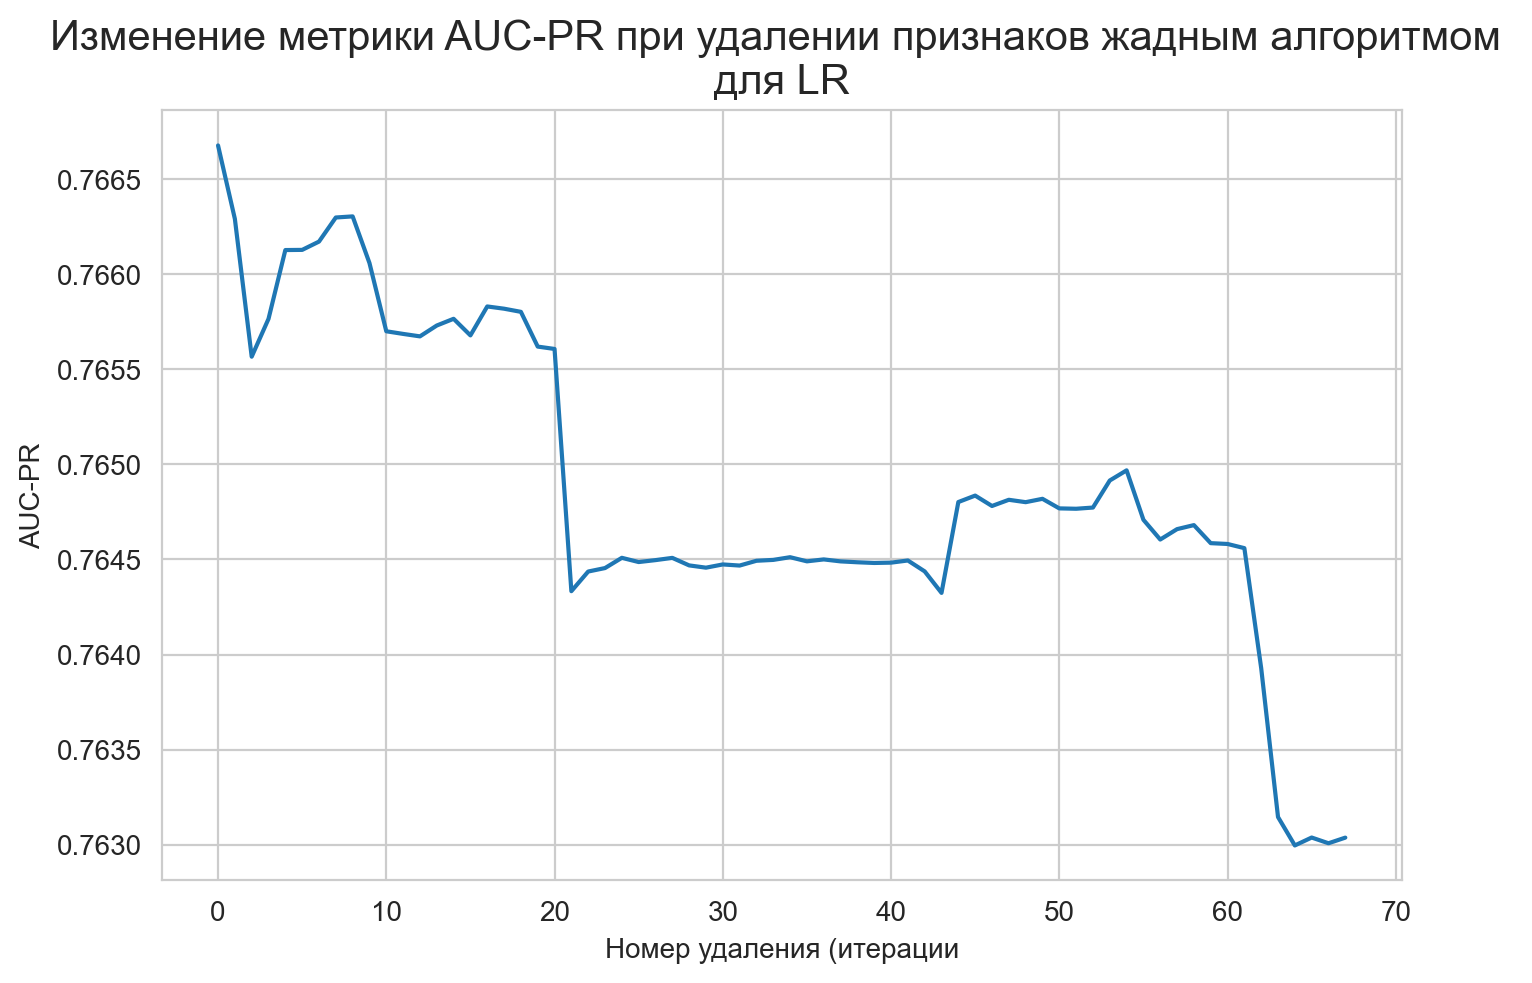

In [184]:
plt.plot(test_qual)
plt.title('Изменение метрики AUC-PR при удалении признаков жадным алгоритмом \nдля LR', fontsize=15)
plt.xlabel("Номер удаления (итерации")
plt.ylabel("AUC-PR");

Видно, что алгоритм жадный: иногда метрика даже повышалась на тесте. При этом периодически мы выходили на некоторое плато, когда удаление признаков не давало сильного падения в качестве.

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [187]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

X_train_new_scaled = column_transformer.fit_transform(X_train_new)
X_val_scaled = column_transformer.transform(X_val)
X_test_scaled = column_transformer.transform(X_test)

lr = LogisticRegression(max_iter=100000, random_state=13).fit(X_train_new_scaled, y_train_new)

In [188]:
qual = []
test_qual = []
idx_best = []
all_features = [i for i in range(X_train_new_scaled.shape[1])]

start_time1 = time.process_time()                   # замеряем процессорное время
start_time2 = time.perf_counter()                   # замеряем обычное время

while len(idx_best) < 40:
    qual = []
    for i in all_features:
        newlist = all_features[:] # копируем текущий список индексов
        newlist.remove(i)     # удаляем по очереди по одному из оставшихся индексов

        # обучаемся
        new_lr = LogisticRegression(max_iter=100000, random_state=13)
        new_lr.fit(X_train_new_scaled[:, newlist], y_train_new)
        y_pred = new_lr.decision_function(X_val_scaled[:, newlist])
        iter_aucpr = auc_pr(y_val, y_pred)

        # добавляем качество без i-го индекса
        qual.append(iter_aucpr)

    good_idx = np.argmin(qual)  # смотрим, при удалении какого признака качество изменилось больше всего
    idx_best.append(all_features[good_idx])      # добавляем его к лучшим
    all_features.remove(all_features[good_idx])  # удаляем его из общего списка

    # лагируем качество на тесте на текущих лучших признаках
    test_lr = LogisticRegression(max_iter=100000, random_state=13)
    test_lr.fit(X_train_new_scaled[:, idx_best], y_train_new)
    y_pred = test_lr.decision_function(X_test_scaled[:, idx_best])
    iter_aucpr = auc_pr(y_test, y_pred)
    test_qual.append(iter_aucpr)


finish_time1 = time.process_time()
finish_time2 = time.perf_counter()

delta_time_process1 = finish_time1 - start_time1
delta_time_counter1 = finish_time2 - start_time2

print(f'Процессорное время составило: {round(delta_time_process1, 5)} сек.')
print(f'Классическое время составило: {round(delta_time_counter1, 5)} сек. \n')


Процессорное время составило: 1149.3125 сек.
Классическое время составило: 1161.44392 сек. 



In [190]:
# check
1149 // 60, len(idx_best)

(19, 40)

In [191]:
# итоговое качество
test_lr = LogisticRegression(max_iter=100000, random_state=13)
test_lr.fit(X_train_new_scaled[:, idx_best], y_train_new)
y_pred = test_lr.decision_function(X_test_scaled[:, idx_best])
iter_aucpr = auc_pr(y_test, y_pred)

print(f'Качество (AUC-PR) после составило: {round(iter_aucpr, 5)}')

Качество (AUC-PR) после составило: 0.67435


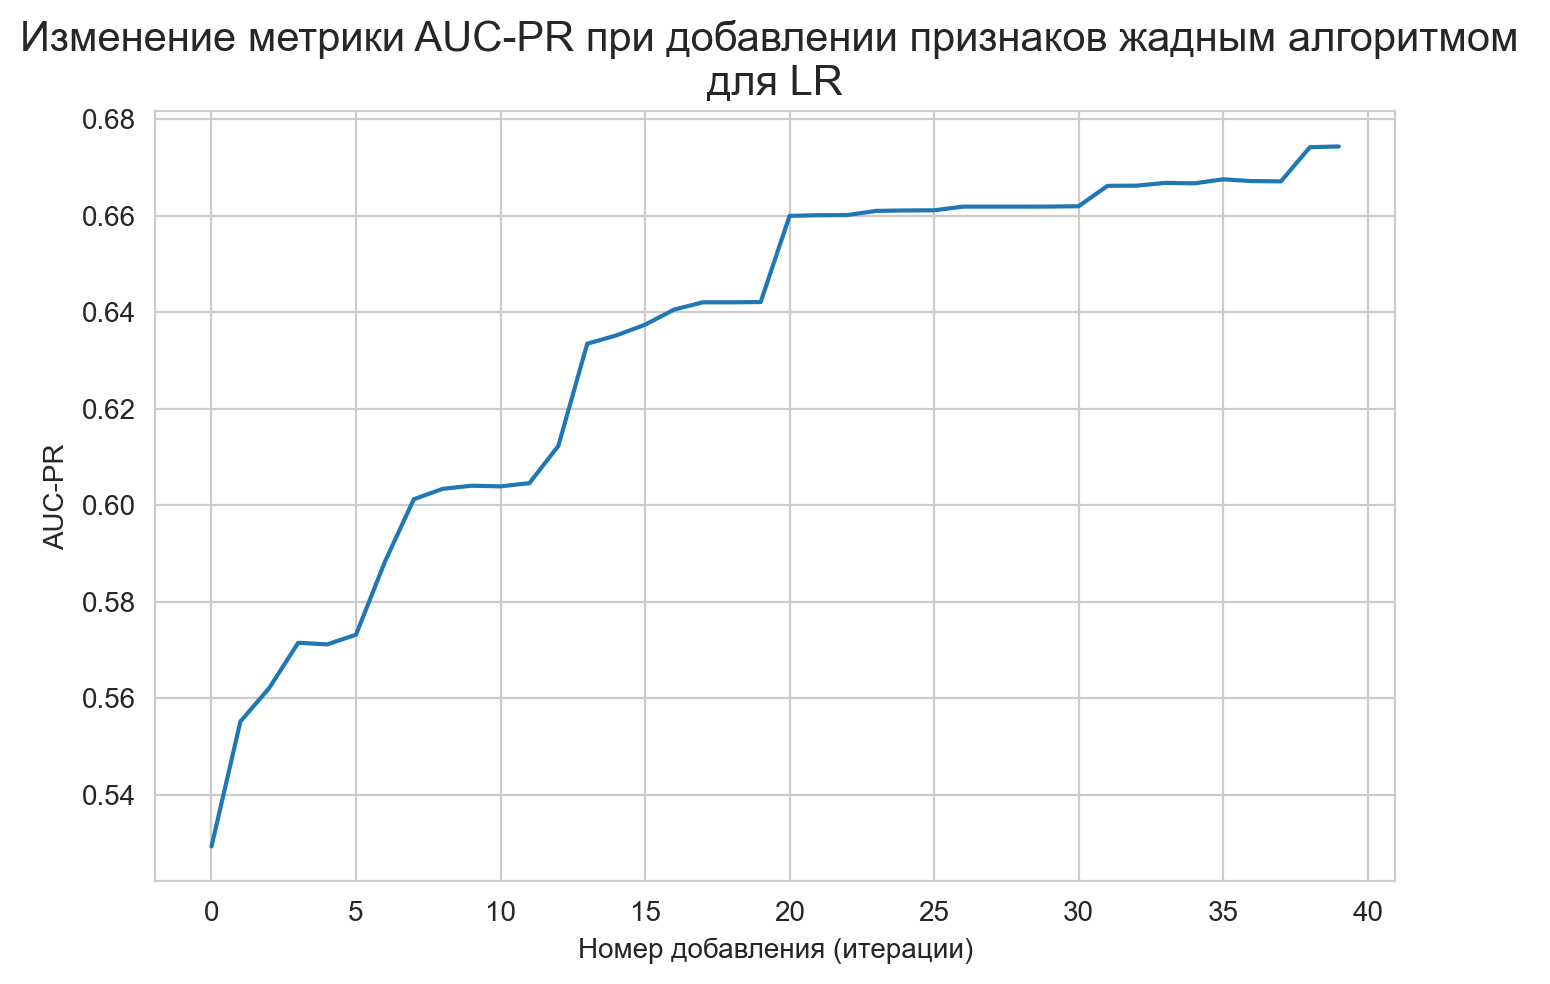

In [192]:
plt.plot(test_qual)
plt.title('Изменение метрики AUC-PR при добавлении признаков жадным алгоритмом \nдля LR', fontsize=15)
plt.xlabel("Номер добавления (итерации)")
plt.ylabel("AUC-PR");

Такой алгоритм оказался хуже: качество по итогам его работы составило на 0.09 меньше, чем при удалении бесполезных признаков - это звучит логично. При этом по времени он работал также долго: 19 мин. проотив 25 мин.

Кривая получилась неубывающей, ведь мы добавляли самые важные признаки, при этом не так уж и много. Хотя, кажется, на третьей итерации качество совсем немного уменьшилось, но это не отражает общей сути. Снова видны "плато" и резкие скачки вверх.

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** во-первых, шкалирование признаков априори работает очень хорошо: и с т.з. качества, и с т.з. времени. Во-вторых, one-hot кодирование показало лучший результат. Да, при прочих равных он работает долго и сильно раздувает признаковое пространство, но наши данные не имели столь большой размерности, их было немного, поэтому этот подход работал хорошо и быстро. Встроенные методы работают очень неплохо и быстро (опять же, в совокупности с нормированием): качество практически не ухудшается, а вот методы-обёртки работают хорошо, но очень (непозволительно) долго.

# Часть 4. Оценка экономического эффекта модели

> В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: 
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

> Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [93]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip  # doesnt work locally but works in collab

wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip', 'bank-additional.zip')  # works locally
!unzip bank-additional.zip

Archive:  bank-additional.zip
   creating: bank-additional/      
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/             
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [239]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [240]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [241]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [242]:
categorical_features = list(X.dtypes[X.dtypes == "object"].index)
numeric_features = list(X.dtypes[(X.dtypes == "int64") | (X.dtypes == "float64")].index)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', LogisticRegression(max_iter=100000, random_state=13))
])

In [119]:
metrics = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = pipeline.fit(X_train, y_train)
    y_pred = model.decision_function(X_test)
    auc_pr_lr = auc_pr(y_test, y_pred)

    metrics.append(auc_pr_lr)

In [120]:
metrics

[0.45578520703423414,
 0.45138227194000813,
 0.4161766648405096,
 0.46924288940710723,
 0.46360176185997554]

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете? 
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [137]:
profit = []
to_oper = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    prec = precision_score(y_test, y_pred)

    profit.append(prec * y_pred.sum() * 10)
    to_oper.append(y_pred.sum())

m_prof = sum(profit) / len(profit)
m_to_oper = sum(to_oper) / len(to_oper)
std_prof = np.std(np.array(profit))
std_to_oper = np.std(np.array(to_oper))

print('Средняя выручка:', m_prof)
print('Стандартное отклонение выручки:', round(std_prof, 3), '\n')

print('Придется отдать операторам в среднем:', m_to_oper)
print('Стандартное отклонение выплат операторам:', round(std_to_oper, 3))
print('Часть выручки, идущая операторам по фолдам:', to_oper)

Средняя выручка: 2138.0
Стандартное отклонение выручки: 183.782 

Придется отдать операторам в среднем: 324.4
Стандартное отклонение выплат операторам: 19.694
Часть выручки, идущая операторам по фолдам: [321, 339, 288, 343, 331]


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [139]:
import random

profit1 = []
to_oper1 = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    prec = precision_score(y_test, y_pred)

    mon = y_pred.astype(int) * np.random.uniform(0, 20, len(y_pred))
    profit1.append(prec * mon.sum())
    to_oper1.append(y_pred.sum())

m_prof1 = sum(profit1) / len(profit1)
m_to_oper1 = sum(to_oper1) / len(to_oper1)
std_prof1 = np.std(np.array(profit1))
std_to_oper1 = np.std(np.array(to_oper1))

print('Средняя выручка:', m_prof1)
print('Выручка по фолдам:', profit1)
print('Стандартное отклонение выручки:', round(std_prof1, 3), '\n')

print('Придется отдать операторам в среднем:', m_to_oper1)
print('Стандартное отклонение выплат операторам:', round(std_to_oper1, 3))
print('Часть выручки, идущая операторам по фолдам:', to_oper1)

Средняя выручка: 2122.7630426871137
Выручка по фолдам: [2253.976121226508, 2207.4098767926075, 1715.8733089797363, 2260.670294265771, 2175.8856121709478]
Стандартное отклонение выручки: 205.807 

Придется отдать операторам в среднем: 324.4
Стандартное отклонение выплат операторам: 19.694
Часть выручки, идущая операторам по фолдам: [321, 339, 288, 343, 331]


In [223]:
prof = m_prof1 - m_to_oper1
print('Прибыль (скор) :', prof)

Прибыль (скор) : 1798.3630426871136


Среднее значение выручки, в целом, осталось таким же, но стандартное отклонение увеличилось (хотя не сильно): если посмотреть на конкретные значения по фолдам, видно, что выручка может сильно варьироваться от фолда к фолду. 

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [217]:
def prof_max(y, y_pred):
    '''
    Функция считает прибыль на основе предсказаний модели.

    y - истинные метки
    y_pred - предсказания модели: звонить или не звонить модели

    число денег, которое клиент может принести в банк считается как случайная величина,
    равномерно распределенная в интервале [0;20)
    стоимость одного звонка = 1
    '''
    prec = precision_score(y, y_pred)
    mon = y_pred.astype(int) * np.random.uniform(0, 20, len(y_pred))
    give = y_pred.sum()
    prof = (prec * mon.sum()) - give

    return prof

prof_max_scorer = make_scorer(prof_max)

In [221]:
import warnings
warnings.filterwarnings("ignore") # при очень маленьком С результат не сходится

X_cv = column_transformer.fit_transform(X)
reg_set = np.logspace(-4, 1, 10)

searcher = GridSearchCV(LogisticRegression(max_iter=100000), [{"C": reg_set}], scoring=prof_max_scorer, cv=5)
searcher.fit(X_cv, y)

best_reg_c = searcher.best_params_["C"]
print("Лучший параметр регуляризации: %.4f" % best_reg_c)

best_reg_score = searcher.best_score_
print("Лучший score на регуляризации: %.4f" % best_reg_score)

Лучший параметр регуляризации: 0.0013
Лучший score на регуляризации: 1015.2191


*Лучший гиперпараметр получился небольшим: 0.0013. Скор стал меньше (был 1798) - видна роль случайности.*

Построим график зависимости ожидаемой прибыли от коэффициента:

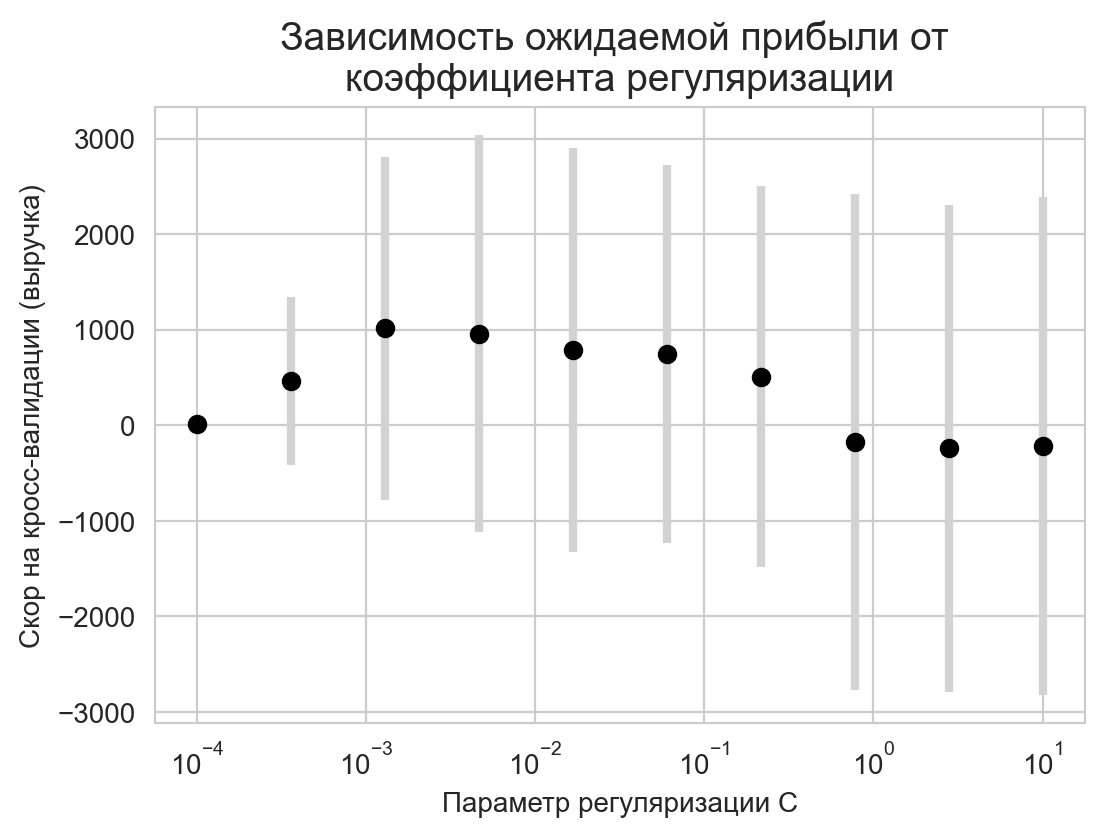

In [224]:
yerr = searcher.cv_results_['std_test_score']

plt.figure(figsize=(6, 4))
plt.errorbar(reg_set, searcher.cv_results_["mean_test_score"], yerr=yerr, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
plt.xscale("log")
plt.title('Зависимость ожидаемой прибыли от \nкоэффициента регуляризации', fontsize=14)
plt.xlabel("Параметр регуляризации C")
plt.ylabel("Скор на кросс-валидации (выручка)");

Смотря на этот график, становится страшно: по сути, начиная с $10^{-3}$ уже нет разницы, какое значение брать из-за сильной случайности результата. При определенных условиях мы можем как получить большую прибыль, так и уйти в минус, хотя большая часть доверительного интервала для найденного значения все-таки в положительной части.

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [225]:
best_params = []
best_scores = []

for _ in range(10):
    searcher = GridSearchCV(LogisticRegression(max_iter=100000), [{"C": reg_set}], scoring=prof_max_scorer, cv=5)
    searcher.fit(X_cv, y)

    best_reg_c = searcher.best_params_["C"]
    best_params.append(best_reg_c)
    # print("Лучший параметр регуляризации: %.4f" % best_reg_c)

    best_reg_score = searcher.best_score_
    best_scores.append(best_reg_score)
    # print("Лучший score на регуляризации: %.4f" % best_reg_score)
    # print('\n')

In [226]:
best_params

[0.001291549665014884,
 0.001291549665014884,
 0.001291549665014884,
 0.001291549665014884,
 0.001291549665014884,
 0.001291549665014884,
 0.001291549665014884,
 0.001291549665014884,
 0.001291549665014884,
 0.001291549665014884]

In [227]:
best_scores

[1027.113750300554,
 1020.5530527839553,
 1010.2420915620114,
 1046.8063305106443,
 1032.1491924361096,
 1004.6012009770504,
 1016.4888844124532,
 1036.6086155540684,
 1047.3739534476022,
 1024.3925658307453]

Видно, что всегда выбирается маленький коэффициент, равный 0.0013. Это логично, ведь мы используем кросс-валидацию, да и логистическая регрессия не склонна переобучаться. Средний скор (прибыль) при нем колеблется не так сильно.

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ важнее recall, поскольку "маржа" очень большая: цена ошибки небольшая, а прибыль большая. Важно выявить как можно больше положительных объектов.

> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [243]:
# считаем recall
from sklearn.metrics import recall_score

grid = np.arange(0.0, 1.0, 0.01)
recalls_cv = []
X_cv = column_transformer.fit_transform(X)

for train_index, test_index in skf.split(X, y):
    recalls_cv_buf = []
    for border in grid:
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = column_transformer.fit_transform(X_train)
        X_test = column_transformer.transform(X_test)

        lr = LogisticRegression(C=best_reg_c, max_iter=100000, random_state=13).fit(X_train, y_train)
        probs = lr.predict_proba(X_test)[:, 1]
        preds = np.array([1 if i > border else 0 for i in probs])

        recall = recall_score(y_test, preds)
        recalls_cv_buf.append(recall)

    recalls_cv.append(recalls_cv_buf)

In [244]:
mean_cv_result = []
std_cv_result = []

for j in range(len(recalls_cv[0])):
    sum = 0
    buf = []
    for i in range(len(recalls_cv)):
        buf.append(recalls_cv[i][j])
    mean = np.mean(np.array(buf))
    std = np.std(np.array(buf))
    mean_cv_result.append(mean)
    std_cv_result.append(std)

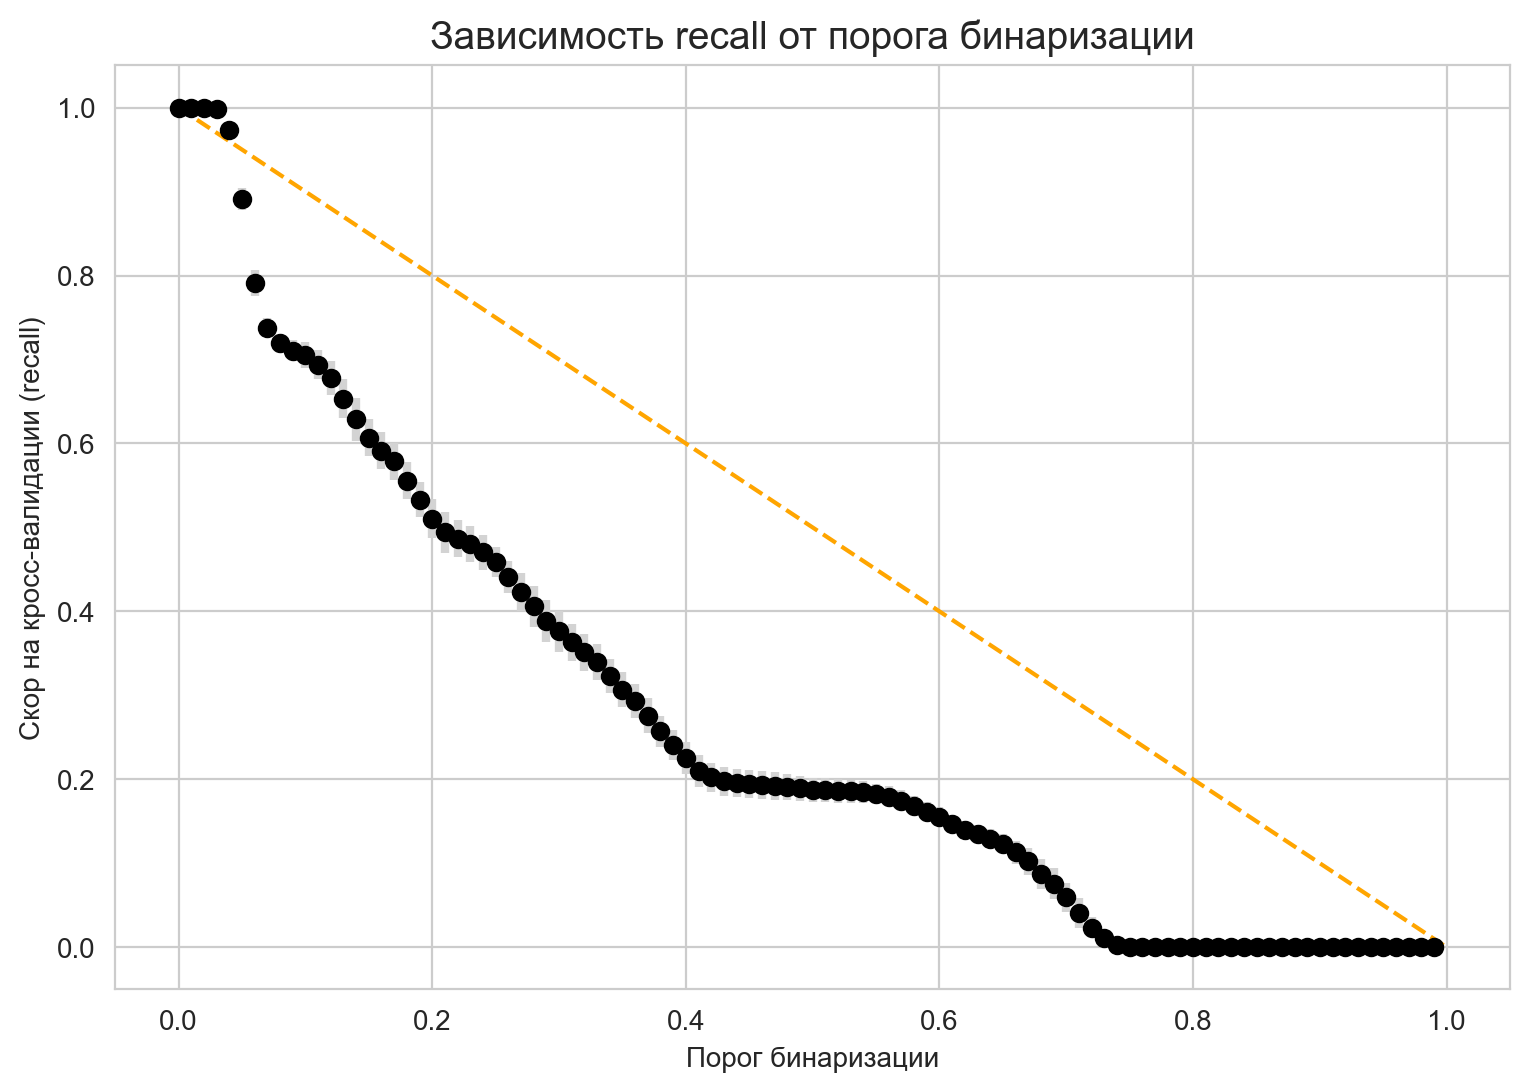

In [245]:
yerr = std_cv_result

plt.figure(figsize=(9, 6))
plt.errorbar(grid, mean_cv_result, yerr=yerr, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
plt.plot([0, 1], [1, 0], '--', label='Идеал', color='orange')
plt.title('Зависимость recall от порога бинаризации', fontsize=14)
plt.xlabel("Порог бинаризации")
plt.ylabel("Скор на кросс-валидации (recall)");

Оранжевая прямая - если бы recall прямо пропорционально зависела от порога.

In [253]:
grid[np.array(mean_cv_result) < 0.5]

array([0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
       0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42,
       0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53,
       0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64,
       0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75,
       0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86,
       0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97,
       0.98, 0.99])

Видна зависимость recall от порога бинаризации. Стандартные ошибки небольшие. Получили логичную картину. 

Recall $\ge 0.5$ при пороге больше 0.21 (потребуется далее в задании).

In [229]:
# прибыль

grid = np.arange(0.0, 1.0, 0.01)
recalls_cv_prof = []
X_cv = column_transformer.fit_transform(X)

for train_index, test_index in skf.split(X, y):
    recalls_cv_buf = []
    for border in grid:
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = column_transformer.fit_transform(X_train)
        X_test = column_transformer.transform(X_test)

        lr = LogisticRegression(C=best_reg_c, max_iter=100000, random_state=13).fit(X_train, y_train)
        probs = lr.predict_proba(X_test)[:, 1]
        preds = np.array([1 if i > border else 0 for i in probs])

        score = prof_max(y_test, preds)
        recalls_cv_buf.append(score)

    recalls_cv_prof.append(recalls_cv_buf)

In [230]:
# считаем прибыль

mean_cv_result_prof = []
std_cv_result_prof = []

for j in range(len(recalls_cv_prof[0])):
    buf = []
    for i in range(len(recalls_cv_prof)):
        buf.append(recalls_cv_prof[i][j])
    mean = np.mean(np.array(buf))
    std = np.std(np.array(buf))
    mean_cv_result_prof.append(mean)
    std_cv_result_prof.append(std)

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

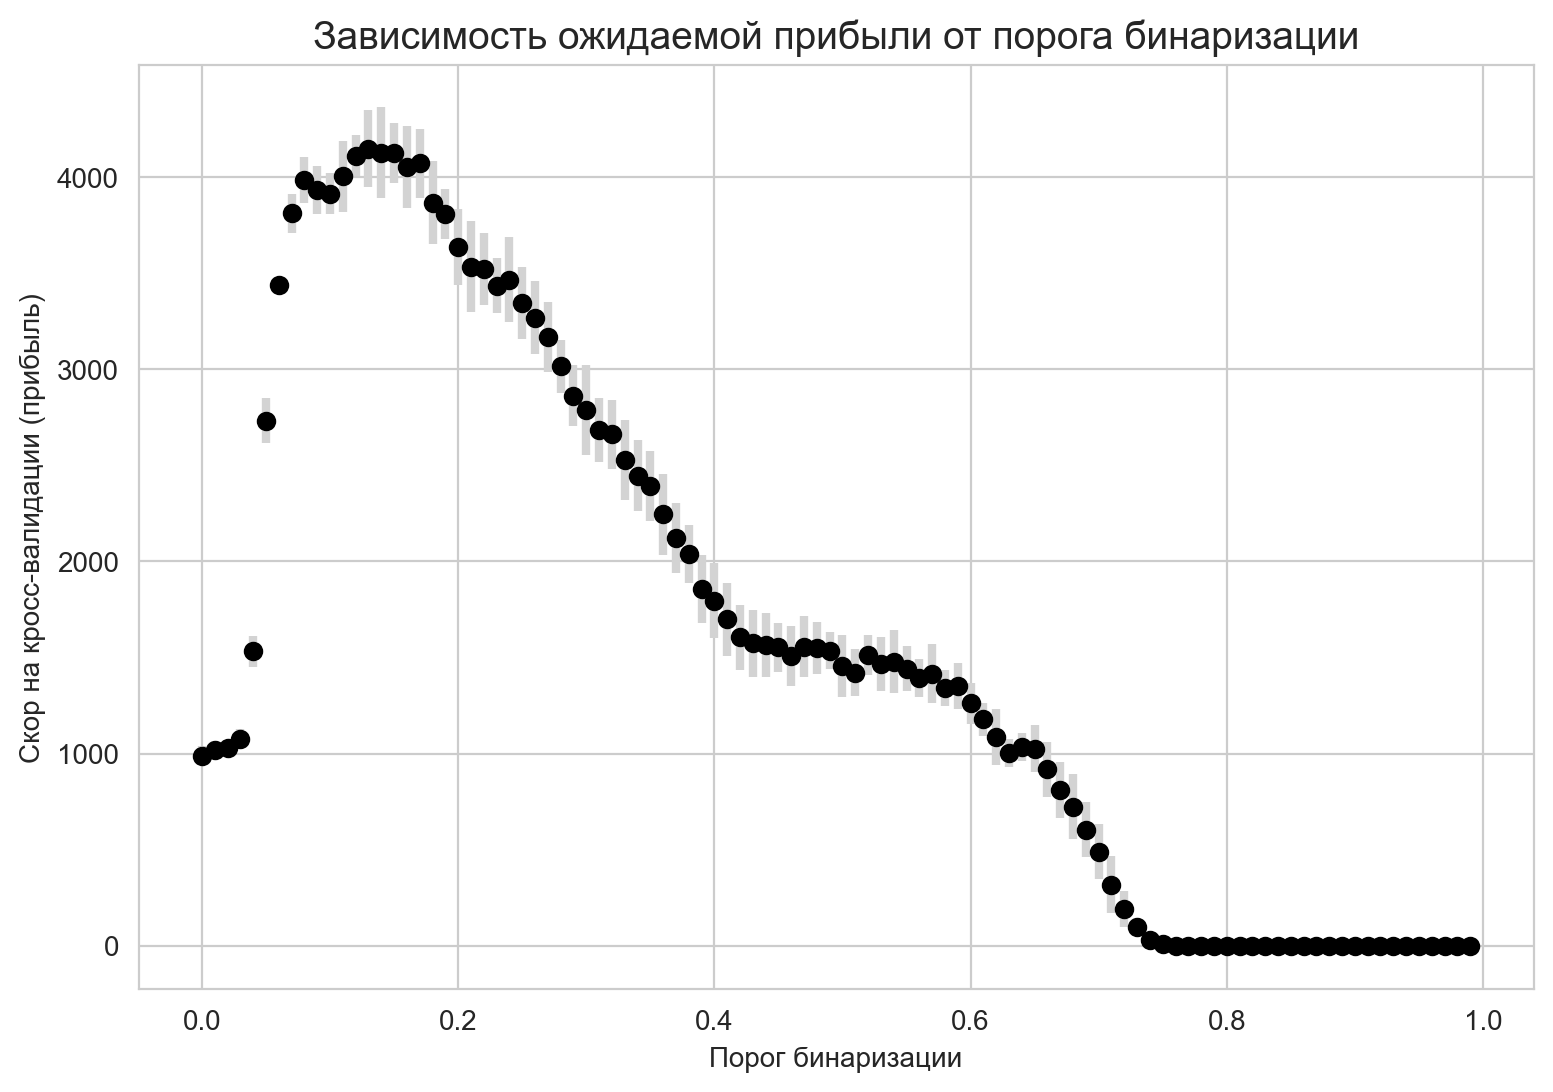

In [231]:
yerr = std_cv_result_prof

plt.figure(figsize=(9, 6))
plt.errorbar(grid, mean_cv_result_prof, yerr=yerr, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
plt.title('Зависимость ожидаемой прибыли от порога бинаризации', fontsize=14)
plt.xlabel("Порог бинаризации")
plt.ylabel("Скор на кросс-валидации (прибыль)");

In [232]:
idx = np.argmax(mean_cv_result_prof)
print(f'Лучший порог равен: {grid[idx]}')

Лучший порог равен: 0.13


Вероятно, лучший порог будет лежать в зоне от 0.1 до 0.2. Запустим алгоритм несколько раз:

In [233]:
grid = np.arange(0.0, 1.0, 0.01)
best_grids = []

for _ in range(5):
    recalls_cv_prof = []
    X_cv = column_transformer.fit_transform(X)

    for train_index, test_index in skf.split(X, y):
        recalls_cv_buf = []
        for border in grid:
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            X_train = column_transformer.fit_transform(X_train)
            X_test = column_transformer.transform(X_test)

            lr = LogisticRegression(C=best_reg_c, max_iter=100000, random_state=13).fit(X_train, y_train)
            probs = lr.predict_proba(X_test)[:, 1]
            preds = np.array([1 if i > border else 0 for i in probs])

            score = prof_max(y_test, preds)
            recalls_cv_buf.append(score)

        recalls_cv_prof.append(recalls_cv_buf)

    mean_cv_result_prof = []
    std_cv_result_prof = []

    for j in range(len(recalls_cv_prof[0])):
        buf = []
        for i in range(len(recalls_cv_prof)):
            buf.append(recalls_cv_prof[i][j])
        mean = np.mean(np.array(buf))
        std = np.std(np.array(buf))
        mean_cv_result_prof.append(mean)
        std_cv_result_prof.append(std)

    idx = np.argmax(mean_cv_result_prof)
    best_grids.append(grid[idx])

In [234]:
best_grids

[0.15, 0.13, 0.14, 0.14, 0.14]

Лучший порог, как и предполагалось, получается в диапазоне $[0.13; 0.15]$ - достаточно небольшой. Это компромисс между стремлением учесть бОльшую часть положительных объектов и тем, чтобы не обзванивать абсолютно всех (ведь сотрудникам колл-центра тоже нужно платить). Это подтверждает гипотезу о том, что ключевая метрика прежде всего связана с recall.

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [236]:
np.mean(np.array(best_grids))

0.14

In [237]:
border = 0.14
recalls_cv_border = []
precisions_cv_border = []
X_cv = column_transformer.fit_transform(X)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = column_transformer.fit_transform(X_train)
    X_test = column_transformer.transform(X_test)

    lr = LogisticRegression(C=best_reg_c, max_iter=100000, random_state=13).fit(X_train, y_train)
    probs = lr.predict_proba(X_test)[:, 1]
    preds = np.array([1 if i > border else 0 for i in probs])

    score = prof_max(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)

    precisions_cv_border.append(precision)
    recalls_cv_border.append(recall)

In [238]:
mean_precisions_cv_border = np.mean(np.array(precisions_cv_border))
mean_recalls_cv_border = np.mean(np.array(recalls_cv_border))

std_precisions_cv_border = np.std(np.array(precisions_cv_border))
std_recalls_cv_border = np.std(np.array(recalls_cv_border))

print(f'Порог: {border}')
print(f'Среднее значение precision = {mean_precisions_cv_border}')
print(f'Стандартное отклонение precision {std_precisions_cv_border} \n')
print(f'Среднее значение recall = {mean_recalls_cv_border}')
print(f'Стандартное отклонение recall {std_recalls_cv_border}')

Порог: 0.14
Среднее значение precision = 0.34402090064725327
Стандартное отклонение precision 0.006187413123797701 

Среднее значение recall = 0.6288793103448276
Стандартное отклонение recall 0.025533108999344634


*precision получается относительно небольшим (0.34), а recall - большим (0.63).*

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

In [262]:
lr = LogisticRegression(C=best_reg_c, max_iter=100000, random_state=13).fit(X_train, y_train)
y_pred = lr.predict_proba(X_test)[:, 1]

AUC-PR: 0.43616


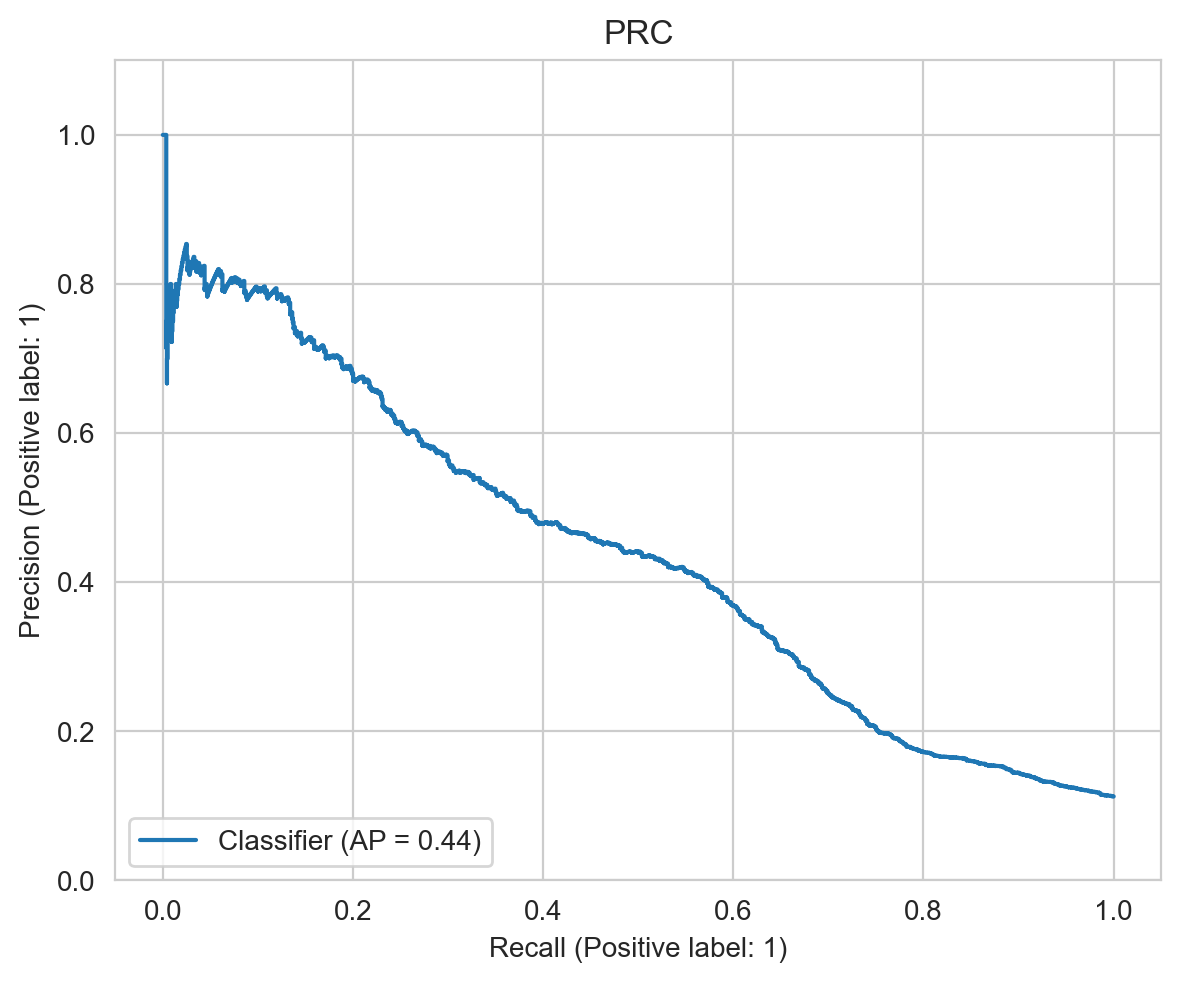

In [274]:
fig, ax = plt.subplots(figsize=(6, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax.set_title("PRC")
ax.set_ylim(0, 1.1)

plt.tight_layout();

*Общая площадь AUC-PR составляет 0.43616.*

В начале попробую оценить сокращенную кривую напрямую:

In [293]:
newrecall = recall[recall >= 0.5]
newprecision = precision[recall >= 0.5]

auc(newrecall, newprecision)

0.12156996951151502

AUC-PR получилась 0.12.

Далее рассмотрим отсеченный прямоугольник как единичный квадрат:

In [312]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler() # по умолчанию вытягивает в [0; 1]

In [315]:
minmaxrecall = minmax.fit_transform(newrecall.reshape(-1, 1))
minmaxprecision = minmax.fit_transform(newprecision.reshape(-1, 1))

auc(minmaxrecall, minmaxprecision)

0.39856135722679387

Если рассматривать новую отсеченную область как единичный квадрат, AUC-PR получится примерно 0.4